# Is Monday Effect an Urban Myth?

**Authors**: Blythe King, Dinggyue Lie, Lucy (Yu) Xue\*, Sungbin Youk\
**Date**: June 6th, 2021\
**Description**: As a final project for PSTAT 234 in University of California, Santa Barbara, the authors examined the presence of Monday effect. The authors equally contributed to the project. The names of the authors are in an alphabetical order. The corresponding author is indicated with *.
----

**Table of Contents**
1. [Introduction](#introduction)\
    A. [Predicting the Stock Market](#predicting-the-stock-market)\
    B. [What is Monday Effect](#what-is-monday-effect)\
    C. [Our Objectives](#our-objectives)
2. [Tackling Objective 1](#tackling-objective-1)\
    A. [S&P 500 for 2017](#1_2017)\
    B. [S&P 500 for 2021](#1_2021)
3. [Tackling Objective 2](#tackling-objective-2)\
    A. [S&P 500 for 2017](#2_2017)\
    B. [S&P 500 for 2021](#2_2021)
4. [Tackling Objective 3](#tackling-objective-3)\
    A. [S&P 500 for 2017](#3_2017)\
    B. [S&P 500 for 2021](#3_2021)
5. [Conclusion](#conclusion)

## Introduction<a clas ="anchor" id = "introduction"></a>

### Predicting the Stock Market <a clas ="anchor" id = "predicting-the-stock-market"></a>

It will be great if you can predict the changes in the stock market. It will make you rich. Isn't that everyone's dream? Unfortunately, [efficient market hypothesis](https://www.investopedia.com/terms/e/efficientmarkethypothesis.asp) postulates that generating a stable parameter that reflects the share prices is impossible as the share prices reflect all information. 

It would be against the efficient market hypothesis if there is a predictable *pattern* in the stock market. In 1973, [Frank Cross](https://www.jstor.org/stable/pdf/4529641.pdf?refreqid=excelsior%3Adeff8e6e9e2c4c0b275b4b03a21b9c13) documented a non-random movement in stock prices. Here are the main findings from examining the Standard & Poor's Composite Stock Index from 1953 to 1970:
- The index have risen on Friday more often than on any other days of the week, and have risen least often on Monday. 
- When the Friday index declined, the Monday index was more likely to also see a decline. When the Friday index advanced, the Monday index was likely to remain static (neither advancing nor declining). 

### What is Monday Effect? <a clas ="anchor" id = "what-is-monday-effect"></a>

Over the years, Frank Cross's findings were coined into what is now known as the **Monday Effect**. There are two different definitions of the monday effect (each corresponding to the two findings that are mentioned above). 

- Monday effect states that the returns on Monday are less than the other days of the week, and are often negative on average ([Pettengill, 2003](https://www.jstor.org/stable/pdf/23292837.pdf?refreqid=excelsior%3A6da162ff7d91746d901fc154171e6015)).
- Monday effect states that the returns on the stock market on Monday, especially the first few hours, will follow the pattern of the previous Friday, espeically the last few hours ([Investopedia](https://www.investopedia.com/terms/m/mondayeffect.asp)). 

You may wonder what may be the reason behind this abnormality in the stock prices. As the existence of Monday effect is controversial (thus, the reason for our project), there isn't a clear answer. Some state that the stock returns are low on Monday because companies may hold on to bad news until the last day of stock trading (Friday), which in turn makes the next stock trading day (Monday) to take the hit. 

### Our Objectives <a clas ="anchor" id = "our-objectives"></a>

The objective of our project is in three-folds:
1) The first objective is to examine the first definitoin of Monday effect (i.e. the stock returns of Monday is less than the other days of the week). We will benchmark [Arman and Lestari's study](https://www.atlantis-press.com/proceedings/icame-18/125917114). They examined Monday effect in the Indonesian Stock Exchange. We will examine if Monday effect is also present in the U.S. stock market.
2) The second objective of this study is to examine the second definition of Monday effect. We will examine if Monday's returns are correlated to that of Friday.
3) We will take a step further and apply time series analysis to see "abnormailities" is stock returns.

----
## Tackling Objective 1 <a clas ="anchor" id = "tackling-objective-1"></a>

In our analysis, the stock return data are obtained from yfinance package in python. We will create two sets of data. The first data will include the stock returns of S&P 500 from 2014 to 2017. This data set has the identical timeframe to that of Arman and Lestari's study. The second dataset includes the latest S&P 500 constituents. 

### A Short Summary of Arman and Lestari's Study

Arman and Lestari examined the Monday effect by examining the banking sectors on the Indonesian stock market from 2014 to 2017. A one-sample t-test was conducted for each of the weekdays with the test value of 0. Therefore, they examined if the average stock returns (i.e., stock price of that day minus that of the previous day) for a specific day of the week is significantly different from 0. The results indicated that the average stock return on Monday is -0.0006, which was not statistically significant. In addition, they also examined another calendar effect by looking at monthly stock returns. They found Aprial and June to have significantly negative stock returns. Although the statistics were significant for these months, the effect size is small to have significant practical effect. 

### Importing Libraries and Packages

In [24]:
import yfinance as yf
import numpy as np
import pandas as pd
import requests
import datetime
from datetime import date
import calendar
import io
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Importing the list of ticker for S&P 500 between 2014 to 2017  <a clas ="anchor" id = "1_2017"></a>

The first step is to retrieve the companies that constituted S&P 500 in the past. 

In [3]:
# Downloading the csv file from a Github page which has a list of companies and when they were added or removed from S&P 500
url = "https://raw.githubusercontent.com/leosmigel/analyzingalpha/master/sp500-historical-components-and-changes/sp500_history.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

#Turning the date column into a datetime object
df["date"] = pd.to_datetime(df["date"])

# Printing out the first 5 rows of the dataframe
df.head()

,Unnamed: 0,cik,date,name,value,variable
0,183,72741.0,1957-01-01,Eversource Energy,ES,added_ticker
1,228,874766.0,1957-01-01,Hartford Financial Svc.Gp.,HIG,added_ticker
2,435,1113169.0,1957-01-01,T. Rowe Price Group,TROW,added_ticker
3,349,1111711.0,1957-01-01,NiSource Inc.,NI,added_ticker
4,185,1109357.0,1957-01-01,Exelon Corp.,EXC,added_ticker


In [4]:
# Function to retrieve the tickers in S&P 500 for a given timeframe
def past_SP_ticker(end_date):
    ticker_list = []
    global df
    for index,row in df.iterrows():
        if row['date'] > end_date:
            break
        else:
            if row['variable'] == "added_ticker":
                ticker_list.append(row['value'])
            elif row['value'] in ticker_list:
                ticker_list.remove(row['value'])
    return ticker_list

In [5]:
# Using the past_SP_ticker() function to retrieve the tickers of S&P 500 for 2017. 
end_date = '20171231'
date_time_obj = datetime.datetime.strptime(end_date,'%Y%m%d')
SP_ticker_2017 = past_SP_ticker(date_time_obj)

### Creating a dataframe of stock returns for the identified S&P 500 constituents of 2017
The next step is to obtain the daily stock returns of the selected companies. This requires several steps: obtain the stock data of the S&P 500 constituents of 2017, delete the missing values, calculate the log retruns, create a multilevel index (i.e., hierarchical index) with the days of the week

#### Obtaining the stock data of S&P 500 constituents of 2017

In [6]:
# Using the ticker to obtain stock prices from yfinance
rawdata = yf.download(SP_ticker_2017, start="2013-12-31", end="2017-12-31")
rawdata.columns = rawdata.columns.set_names(['Value', 'Symbol'])
rawdata.head()

[*********************100%***********************]  488 of 488 completed

33 Failed downloads:
- SYMC: No data found, symbol may be delisted
- TIF: No data found, symbol may be delisted
- VIAB: No data found, symbol may be delisted
- FOX: Data doesn't exist for startDate = 1388476800, endDate = 1514707200
- Q: No data found for this date range, symbol may be delisted
- BBT: No data found, symbol may be delisted
- TYC: No data found for this date range, symbol may be delisted
- STI: No data found, symbol may be delisted
- ARNC: Data doesn't exist for startDate = 1388476800, endDate = 1514707200
- ETFC: No data found, symbol may be delisted
- HCP: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- LUK: No data found for this date range, symbol may be delisted
- CXO: No data found, symbol may be delisted
- RTN: No data found, symbol may be delisted
- KORS: No data found for this date range, symbol may be delisted
- WCG: No data found, symbol may be deli

Value       Adj Close                                                          \
Symbol              A        AAL         AAP       AAPL       ABBV        ABC   
Date                                                                            
2013-12-31  38.247646  23.804220  108.574318  17.819056  38.783775  62.277599   
2014-01-02  37.592243  23.907927  107.652184  17.568449  38.174229  61.905617   
2014-01-03  38.067078  25.020357  110.732445  17.182545  38.409229  61.949898   
2014-01-06  37.879810  25.482304  109.672997  17.276247  37.006523  61.728436   
2014-01-07  38.421539  25.369177  111.026726  17.152695  37.079971  62.401627   

Value                                                   ...   Volume           \
Symbol            ABT        ACN       ADBE        ADI  ...      XEL     XLNX   
Date                                                    ...                     
2013-12-31  33.028294  70.729378  59.880001  42.778137  ...  1752800  1215400   
2014-01-02  32.942123  69.791710  59.290001  41.392246  ...  3192300  3436800   
2014-01-03  33.295418  70.023994  59.160000  41.669426  ...  2939400  1982700   
2014-01-06  33.734875  69.284195  58.119999  41.434235  ...  3382300  1970800   
2014-01-07  33.476364  70.127213  58.970001  41.652618  ...  3481500  1581200   

Value                                                                      \
Symbol           XOM     XRAY      XRX     XYL      YUM      ZBH     ZION   
Date                                                                        
2013-12-31   8509600   434400  2033475  558000  2966864   650000  1077400   
2014-01-02  11028100  1025400  3977691  765100  2721213   868800  1356700   
2014-01-03   9295600   623300  2763747  454500  2026826  1288200  1122500   
2014-01-06  11848500   986700  5657131  849400  4083698  1414900  1988200   
2014-01-07  11187000  2218300  5837583  611100  5035003  1852600  1343200   

Value                
Symbol          ZTS  
Date                 
2013-12-31  2270400  
2014-01-02  2576100  
2014-01-03  2524900  
2014-01-06  2763200  
2014-01-07  2338200  

[5 rows x 2928 columns]

#### Deleting the missing values

In [7]:
# Inspecting the missing values in terms of rows
rawdata['Close'].isna().sum(axis=0).describe()

count     488.000000
mean       79.977459
std       262.763277
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1008.000000
dtype: float64

In [8]:
# Making an list of tuples for tickers that has more than 3 missing values
high_missing_ticker = rawdata['Close'].isna().sum(axis=0) > 3
high_missing_ticker_list = high_missing_ticker[high_missing_ticker].index.tolist()
high_missing_ticker_tuples = list()
for i in ['Adj Close', 'Open', 'Close', 'High' ,'Low', 'Volume']:
    high_missing_ticker_tuples += list(zip([i]*len(high_missing_ticker_list),high_missing_ticker_list))

In [9]:
# Excluding columns (i.e., tickers) that has more than 3 missing values 
rawdata = rawdata.drop(high_missing_ticker_tuples, axis = 1)

In [10]:
# Finding out the dates that all tickers (columns) have missing values
missingdate =rawdata.isna().sum(axis=1) > 0
missingdate[missingdate].index

DatetimeIndex(['2015-09-22', '2017-09-01'], dtype='datetime64[ns]', name='Date', freq=None)

In [11]:
# delete the first row if it has missing values
if rawdata.iloc[0].isna().sum().any():
    rawdata = rawdata.iloc[1:]

In [12]:
# other rows with missing values are replaced with the values from the previous date
rawdata = rawdata.fillna(method= 'ffill')

In [13]:
# Double check to see if all the missing values were either removed or replaced
(rawdata.isna().sum(axis=None)>0).any()

False

#### Calculating the log returns for closing price

In [14]:
# Getting the log returns from stock prices
logret = np.log(rawdata['Close']).diff()
logret.columns = pd.MultiIndex.from_product([['logreturn'], logret.columns])
# Joining logret and rawdata 
rawdata = rawdata.join(logret)
# row with the index of 2013-12-31 will be deleted as it is out of the scope of our data (2014~2017)
rawdata = rawdata.drop(pd.Timestamp('2013-12-31'))

In [15]:
print("After preprocessing the data, we have idenified the log returns of {} companies, which were included in S&P500 in 2017. To recap, we are examining the stock returns from 2014 to 2017. Therefore, we will be examining the stock returns of {} days".format(len(logret.columns), len(logret)))

After preprocessing the data, we have idenified the log returns of 440 companies, which were included in S&P500 in 2017. To recap, we are examining the stock returns from 2014 to 2017. Therefore, we will be examining the stock returns of 1008 days


#### Creating a new columns for the industry information

In [16]:
# Obtaining the information about the tickers that are included in SP_ticker_2017
industry_dic = dict()
for item in SP_ticker_2017:
    try:
        industry_dic[item] = yf.Ticker(item).info['industry']
    except:
        industry_dic[item] = None

In [17]:
# Adding the industry to a level of the column
rawdata.columns = pd.MultiIndex.from_tuples([(value, industry_dic[ticker], ticker) for value, ticker in rawdata.columns])
rawdata.head()

Adj Close                              \
           Diagnostics & Research   Airlines Specialty Retail   
                                A        AAL              AAP   
Date                                                            
2014-01-02              37.592243  23.907927       107.652184   
2014-01-03              38.067078  25.020357       110.732445   
2014-01-06              37.879810  25.482304       109.672997   
2014-01-07              38.421539  25.369177       111.026726   
2014-01-08              39.050190  26.047951       110.163490   

                                                            \
           Consumer Electronics Drug Manufacturers—General   
                           AAPL                       ABBV   
Date                                                         
2014-01-02            17.568449                  38.174229   
2014-01-03            17.182545                  38.409229   
2014-01-06            17.276247                  37.006523   
2014-01-07            17.152695                  37.079971   
2014-01-08            17.261322                  36.984486   

                                                 \
           Medical Distribution Medical Devices   
                            ABC             ABT   
Date                                              
2014-01-02            61.905617       32.942123   
2014-01-03            61.949898       33.295418   
2014-01-06            61.728436       33.734875   
2014-01-07            62.401627       33.476364   
2014-01-08            63.012794       33.777969   

                                                                    \
           Information Technology Services Software—Infrastructure   
                                       ACN                    ADBE   
Date                                                                 
2014-01-02                       69.791710               59.290001   
2014-01-03                       70.023994               59.160000   
2014-01-06                       69.284195               58.119999   
2014-01-07                       70.127213               58.970001   
2014-01-08                       70.669174               58.900002   

                           ...                    logreturn                 \
           Semiconductors  ... Utilities—Regulated Electric Semiconductors   
                      ADI  ...                          XEL           XLNX   
Date                       ...                                               
2014-01-02      41.392246  ...                    -0.015510       0.001088   
2014-01-03      41.669426  ...                    -0.000364      -0.007643   
2014-01-06      41.434235  ...                    -0.005469      -0.004394   
2014-01-07      41.652618  ...                     0.017039       0.002199   
2014-01-08      41.753410  ...                    -0.003962       0.008531   

                                                                \
           Oil & Gas Integrated Medical Instruments & Supplies   
                            XOM                           XRAY   
Date                                                             
2014-01-02            -0.014432                      -0.010784   
2014-01-03            -0.002409                       0.004784   
2014-01-06             0.001506                      -0.006036   
2014-01-07             0.014049                       0.015331   
2014-01-08            -0.003270                       0.001849   

                                                                           \
           Information Technology Services Specialty Industrial Machinery   
                                       XRX                            XYL   
Date                                                                        
2014-01-02                       -0.021596                      -0.012798   
2014-01-03                        0.006695                       0.009034   
2014-01-06                  

#### Creating a new columns for days of the week

In [18]:
# The day of the week is added as a new index (creating a hierarchical index)
rawdata['days'] = [calendar.day_name[day.weekday()] for day in rawdata.index]

#### Exporting dataframe as csv

In [19]:
rawdata.to_csv('SP500_2014_2017_multilevel.csv')

#### Staking the Closing and Log returns into one dataframe

For convenience in running some of the statistical analyses, the multilevel data of stock values are stacked into a dataframe. 

In [20]:
# To easily stack the data, it is easier to delete the days and industry information.
rawdata = rawdata.drop('days', axis =1)
rawdata.columns = rawdata.columns.droplevel(1)

In [21]:
# The data is stacked 
stacked_rawdata = rawdata.stack()
stacked_rawdata.reset_index(inplace=True)
stacked_rawdata = stacked_rawdata.rename(columns = {'level_1':'Ticker'})

# Days are added as a new column
stacked_rawdata['days'] = [calendar.day_name[day.weekday()] for day in stacked_rawdata['Date']]

# Industry information is added as a new column
stacked_rawdata['Industry'] = [industry_dic[ticker] for ticker in stacked_rawdata['Ticker']]
stacked_rawdata.head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,logreturn,days,Industry
0,2014-01-02,A,37.592243,40.207439,40.844063,40.164520,40.844063,2678848.0,-0.017284,Thursday,Diagnostics & Research
1,2014-01-02,AAL,23.907927,25.360001,25.820000,25.059999,25.070000,8997900.0,0.004347,Thursday,Airlines
2,2014-01-02,AAP,107.652184,109.739998,111.879997,109.290001,110.360001,542700.0,-0.008529,Thursday,Specialty Retail
3,2014-01-02,AAPL,17.568449,19.754642,19.893929,19.715000,19.845715,234684800.0,-0.014164,Thursday,Consumer Electronics
4,2014-01-02,ABBV,38.174229,51.980000,52.330002,51.520000,52.119999,4569100.0,-0.015842,Thursday,Drug Manufacturers—General


#### Exporting dataframe as csv

In [22]:
stacked_rawdata.to_csv('SP500_2014_2017_stacked.csv')

### Analysis of Monday Effect

Now that we have successfully obtained the stock returns of S&P 500 constituents from 2014 to 2017, we can begin with our analysis. We will examine the patterns in stock returns across companies and industries to get a general picture. 

Since we have exported our data to .csv files, we will import the .csv rather than using `rawdata` variable. For those of you who are more interested in the analysis, rather than the data collection process, you can start the notebook from here.

In [13]:
# We will the log returns of the constituents and dropping the industry level
multilevel = pd.read_csv('SP500_2014_2017_multilevel.csv', header=[0,1,2], index_col=0)
logret = multilevel['logreturn'].droplevel(0, axis =1)
logret.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,-0.017284,0.004347,-0.008529,-0.014164,-0.015842,-0.005991,-0.002612,-0.013346,-0.009902,-0.032934,...,-0.015510,0.001088,-0.014432,-0.010784,-0.021596,-0.012798,-0.006901,-0.010247,-0.010401,-0.010146
2014-01-03,0.012552,0.045480,0.028211,-0.022211,0.006137,0.000715,0.010667,0.003323,-0.002195,0.006674,...,-0.000364,-0.007643,-0.002409,0.004784,0.006695,0.009034,0.006240,0.004327,0.007058,-0.009626
2014-01-06,-0.004931,0.018294,-0.009614,0.005438,-0.037204,-0.003581,0.013112,-0.010621,-0.017736,-0.005660,...,-0.005469,-0.004394,0.001506,-0.006036,0.008306,-0.001742,-0.000794,0.006456,-0.007058,-0.002186
2014-01-07,0.014200,-0.004449,0.012268,-0.007177,0.001983,0.010846,-0.007692,0.012094,0.014519,0.005257,...,0.017039,0.002199,0.014049,0.015331,0.008237,0.002902,0.013942,0.019752,0.003031,0.003745
2014-01-08,0.016230,0.026404,-0.007806,0.006313,-0.002578,0.009747,0.008969,0.007699,-0.001188,0.002417,...,-0.003962,0.008531,-0.003270,0.001849,-0.009065,-0.000580,-0.000392,0.024205,0.008704,-0.011278


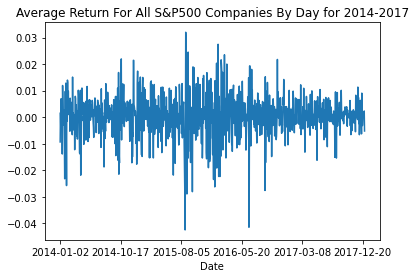

In [4]:
# Let's plotthe average returms
np.mean(logret, axis = 1).plot()
plt.title("Average Return For All S&P500 Companies By Day for 2014-2017")
plt.show()

In [15]:
# As we have imported the data again, we have to specify that our index is in datetime
logret.index = pd.to_datetime(logret.index)
# Let's retrieve the day of the week as the index and drop other columns that are not log returns
logret['Day of Week'] = logret.index.dayofweek
groupeddata = logret.groupby('Day of Week')
mean_per_stock = groupeddata.mean()
mean_per_stock.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
Day of Week,,,,,,,,,,,,,,,,,,,,,
0,-0.000728,-0.000018,-0.000295,0.002913,-0.000918,0.000392,-0.000081,0.000699,-0.000951,0.000875,...,0.000995,0.000945,-0.000242,-0.000991,-0.002276,-0.000489,-0.000372,-0.000683,-0.000763,-0.000907
1,0.000380,0.002416,-0.000299,0.000178,0.000190,0.001269,-0.000398,0.001155,0.001225,0.001676,...,0.000265,0.000828,0.000516,0.000973,0.000396,0.001177,0.001111,0.001135,0.000077,0.000608
2,0.002487,0.000540,-0.000321,0.001457,0.002305,0.002221,0.000684,0.000788,0.001616,0.002203,...,-0.000073,0.000580,0.000173,0.001152,0.001555,0.001078,-0.000137,0.000683,0.001687,0.001819
3,-0.000146,0.000545,0.000040,-0.000772,0.000788,-0.001855,0.001494,0.000610,0.001566,-0.001591,...,0.001483,-0.000443,-0.000195,0.000176,-0.000450,0.000872,-0.000290,-0.000343,0.000878,0.001467
4,0.000315,0.000016,0.000356,0.000082,0.000492,-0.000771,0.000248,-0.000182,0.001717,-0.000438,...,0.000079,0.000021,-0.001235,0.000076,0.000091,0.000626,0.001660,0.000395,0.000631,0.000790


#### Descriptive Analaysis
Let's start with the basic descriptive statistics. Here are the mean log returns across all the stocks returns for each days of the week.\
0 indicates Monday, 2 Tuesday, 3 Wednesday, 4 Thursday, 5 Friday

In [16]:
np.mean(mean_per_stock, axis = 1)

Day of Week
0   -0.000102
1    0.000388
2    0.000969
3    0.000232
4    0.000301
dtype: float64

When we just look at the mean, it seems as if the average stock returns from 2014 to 2017 across companies is lowest on Monday. Let's visualize this.

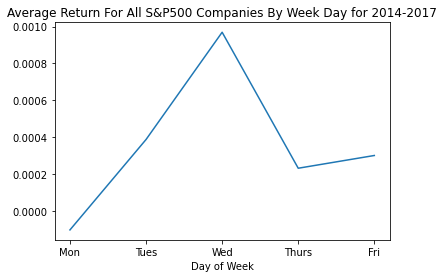

In [17]:
# Let's plot them to clearly see the difference
np.mean(mean_per_stock, axis = 1).plot()
plt.title("Average Return For All S&P500 Companies By Week Day for 2014-2017")
plt.xticks([0, 1, 2, 3, 4], ["Mon", "Tues", "Wed", "Thurs", "Fri"], rotation='horizontal')
plt.show()

The visualization clearly shows that Monday has the lowest average returns. To see if the Monday average return is significantly lower than any other day, run an ANOVA test if mean returns of each day are significantly different.

#### ANOVA

In [20]:
# let's conduct a oneway ANOVA on the five days of the week
fval, pval = stats.f_oneway(np.array(mean_per_stock.iloc[0].array), np.array(mean_per_stock.iloc[1].array), np.array(mean_per_stock.iloc[2].array), np.array(mean_per_stock.iloc[3].array), np.array(mean_per_stock.iloc[4].array))
print("F = {}, p = {}".format(fval,pval))

F = 63.1277408830443, p = 1.4350620154920426e-50


According to this test (assuming a significance level $\alpha$ = .05), the means across days are significantly different across the board. Next, see which day(s) is/are significantly different than the rest:

In [23]:
# We will conduct pair-wise comparison
dfTukey = pd.DataFrame({'return': np.reshape(mean_per_stock.values, -1),
                   'day': np.repeat(mean_per_stock.index, repeats=len(mean_per_stock.iloc[1,:]))})

tukey = pairwise_tukeyhsd(endog=dfTukey["return"], groups = dfTukey["day"], alpha = 0.05)

print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.0005  0.001  0.0003  0.0007   True
     0      2   0.0011  0.001  0.0009  0.0013   True
     0      3   0.0003  0.001  0.0001  0.0005   True
     0      4   0.0004  0.001  0.0002  0.0006   True
     1      2   0.0006  0.001  0.0004  0.0008   True
     1      3  -0.0002 0.1625 -0.0003     0.0  False
     1      4  -0.0001  0.695 -0.0003  0.0001  False
     2      3  -0.0007  0.001 -0.0009 -0.0005   True
     2      4  -0.0007  0.001 -0.0009 -0.0005   True
     3      4   0.0001 0.8396 -0.0001  0.0003  False
----------------------------------------------------


For every Monday pairing, the p-value is significant. Thus, we should reject the null hypothesis that the means of Monday and any other day are the same. However, the same claim can be made for every Wednesday pairing. However, Wednesday is likely significantly higher than any other day, as the average returns on Wednesday is the "peak" in the plot, whereas Monday, having the lowest average returns, are likely significantly lower than any other day.

### Analysis by Month
As done in Arman and Lestari's study, we will examine if there is seasonal abnormaly can be examined in the average stock returns for each month. https://www.investopedia.com/terms/j/januaryeffect.asp

In [24]:
# Let's organize our data in terms of the months
logret['Month of Year'] = logret.index.month

groupeddata = logret.groupby('Month of Year')
mean_per_stock_month = groupeddata.mean()

# Let's get some overview of the average stock returns of each company looks for each month
mean_per_stock_month

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS,Day of Week
Month of Year,,,,,,,,,,,,,,,,,,,,,
1,-0.001207,0.000740,0.000197,-0.001074,-0.003146,-0.000360,-0.001719,-0.001352,-0.000045,-0.001404,...,-0.000913,-0.002800,-0.002037,-0.000822,-0.002076,-0.001271,0.001255,-0.005256,-0.002026,2.150000
2,0.001668,0.002188,0.000081,0.003332,0.000553,0.001315,0.003089,0.001730,0.003448,0.003126,...,0.002066,0.000706,0.002459,0.001366,0.002940,0.002749,0.000446,0.002493,0.000257,2.077922
3,0.000696,-0.000038,-0.000214,0.001763,0.000840,0.000372,0.000081,0.001299,0.000923,0.002602,...,0.000292,0.000275,-0.000370,0.001175,0.000401,0.000993,0.001391,0.000715,0.000144,1.954545
4,0.000346,-0.003554,-0.001911,-0.000613,0.002319,-0.001138,-0.001003,-0.000181,-0.000043,-0.002152,...,-0.001523,0.001541,-0.000606,-0.002618,0.001608,0.001331,0.000213,0.000728,0.001373,1.951220
5,0.003027,0.000578,0.000193,0.002799,0.001239,0.001021,0.001690,0.001537,0.002350,0.003233,...,0.002803,-0.000606,0.001483,0.000420,0.000724,0.002170,0.001937,0.000314,0.002866,2.083333
6,-0.001240,-0.000835,0.000401,-0.001301,0.001431,0.000252,0.000992,-0.000634,0.001123,-0.001782,...,-0.001462,0.000371,0.000120,-0.001115,0.001393,0.000852,0.000135,0.001235,0.000238,1.988506
7,0.001489,0.001573,-0.000105,0.001348,-0.000040,0.001371,0.002416,0.000956,0.000292,-0.000553,...,-0.001319,-0.001519,0.000792,0.002931,-0.000969,-0.001007,-0.000675,0.001139,0.001179,2.023810
8,-0.000522,-0.001423,-0.000977,0.001277,-0.000212,-0.002100,-0.001563,-0.000378,0.001101,0.000267,...,0.001511,-0.001298,-0.002139,-0.000380,0.001636,-0.000236,-0.000956,-0.000072,0.000019,1.965909
9,-0.000783,-0.000328,-0.000100,-0.000457,0.000676,-0.001158,-0.000981,0.001657,0.000323,0.000441,...,0.001043,0.000062,-0.000709,-0.000337,0.000040,-0.000549,-0.000695,0.000447,-0.000117,2.108434


#### Descriptive statistics

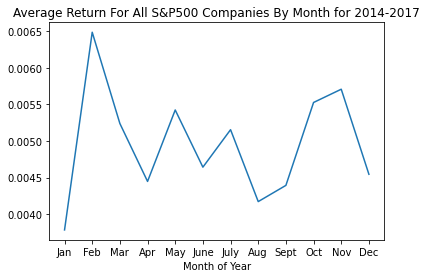

In [25]:
# Let's plot the average log returns of each of the company
np.mean(mean_per_stock_month, axis = 1).plot()
#plt.ylim([70, 90])
plt.title("Average Return For All S&P500 Companies By Month for 2014-2017")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"], rotation='horizontal')
plt.show()

The graph shows that the average stock return is lowest in January. We will conduct one-way ANOVA to examine whether the different sotck returns for each months of the year is statistically significant. 

#### ANOVA

In [114]:
# let's conduct a oneway ANOVA on the 12 months of a year
fval, pval = stats.f_oneway(np.array(mean_per_stock_month.iloc[0].array), np.array(mean_per_stock_month.iloc[1].array), np.array(mean_per_stock_month.iloc[2].array), np.array(mean_per_stock_month.iloc[3].array), np.array(mean_per_stock_month.iloc[4].array),np.array(mean_per_stock_month.iloc[5].array), np.array(mean_per_stock_month.iloc[6].array), np.array(mean_per_stock_month.iloc[7].array), np.array(mean_per_stock_month.iloc[8].array), np.array(mean_per_stock_month.iloc[9].array), np.array(mean_per_stock_month.iloc[10].array), np.array(mean_per_stock_month.iloc[11].array))
print("F = {}, p = {}".format(fval,pval))

F = 0.02757836303583597, p = 0.9999999040224181


With a significance level alpha = 0.05, we fail to reject the null and can currently claim that there is no difference in returns across months. Remember, we are still interested in Monday effect. Since we started to look at the data in terms of the month, we will take advantage of this. Next, we try subsetting the data by month and test Monday effect of each month.

### Examining Monday Effect for Each Month

In [27]:
# First, we will group the data by the month and then by days of the week. This creates a multilevel index
groupeddata = logret.groupby(['Month of Year', 'Day of Week'])
# Next, we will calculate the average stock returns for each of the company
mean_per_stock_months_and_days = groupeddata.mean()
mean_per_stock_months_and_days.head()

A       AAL       AAP      AAPL      ABBV  \
Month of Year Day of Week                                                     
1             0           -0.007968 -0.013658 -0.001970 -0.002447 -0.012029   
              1            0.001254  0.007250  0.004488 -0.003428 -0.003402   
              2            0.001265  0.002927 -0.004339 -0.000035 -0.005824   
              3           -0.002854  0.009473 -0.000579  0.001213  0.006157   
              4            0.000334 -0.006000  0.002354 -0.001019 -0.003386   

                                ABC       ABT       ACN      ADBE       ADI  \
Month of Year Day of Week                                                     
1             0           -0.004965 -0.003974 -0.008216 -0.009331 -0.004123   
              1            0.008901  0.001367  0.002174  0.001647 -0.000988   
              2           -0.001724 -0.005297 -0.000926 -0.002294 -0.000523   
              3           -0.004186 -0.002424 -0.001036  0.004249 -0.004567   
              4           -0.001213  0.000717 -0.000782  0.002489  0.002219   

                           ...       XEL      XLNX       XOM      XRAY  \
Month of Year Day of Week  ...                                           
1             0            ... -0.004467 -0.006837 -0.012033 -0.008416   
              1            ...  0.006382 -0.000030  0.002813  0.005703   
              2            ...  0.000984 -0.000002 -0.006931 -0.004264   
              3            ...  0.004473 -0.003512 -0.000082 -0.001584   
              4            ...  0.000487  0.003845 -0.000841 -0.003542   

                                XRX       XYL       YUM       ZBH      ZION  \
Month of Year Day of Week                                                     
1             0           -0.011114 -0.012360 -0.008580  0.001515 -0.016836   
              1            0.011240  0.001202  0.002789  0.010427 -0.003865   
              2           -0.002860  0.002347 -0.001714  0.001626 -0.002638   
              3            0.001149 -0.002866  0.000047 -0.006130 -0.002556   
              4           -0.005405 -0.001500 -0.001086 -0.000934 -0.003725   

                                ZTS  
Month of Year Day of Week            
1             0           -0.009625  
              1           -0.001417  
              2           -0.001793  
              3           -0.000202  
              4            0.000533  

[5 rows x 440 columns]

#### Descriptive Statistics
Instead of shwoing 60 different stock returns (12 months x 5 days), let's dive right into visualizing the data. 

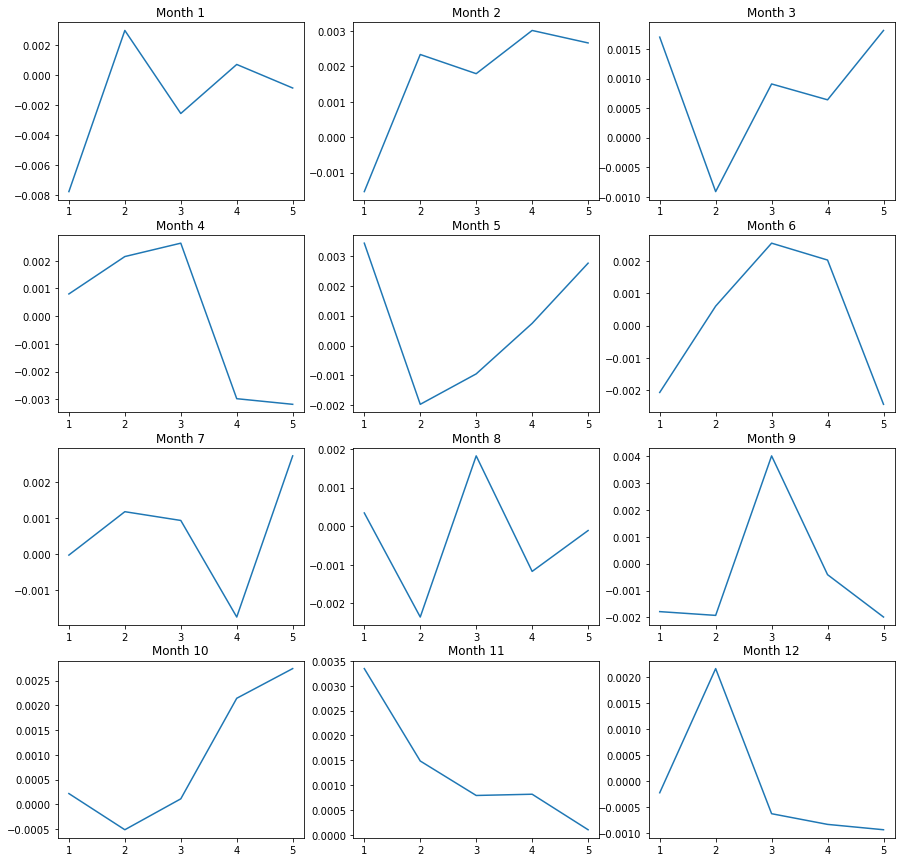

In [78]:
fig, ax = plt.subplots(4,3, figsize=(15,15))
plt.title("Average Returns by Day by Month")

## Write a for loop
for i in range(1,13):
    temp_mean_per_stock = mean_per_stock_months_and_days.iloc[mean_per_stock_months_and_days.index.get_level_values('Month of Year') == i]
    x = (i-1)//3
    y = (i-1)%3
    ax[x,y].plot(range(1,6), np.mean(temp_mean_per_stock, axis = 1).values)
    ax[x,y].set_title('Month %i' % (i))
plt.show()

For each month, there seems to be fluctuation in the stock returns across the week. Let's see if they are statistically significant, we will run oneway ANOVA for each month. 

#### ANOVA

In [115]:
pvals_months = []

for i in range(1,13):
        temp_mean_per_stock = mean_per_stock_months_and_days.iloc[mean_per_stock_months_and_days.index.get_level_values('Month of Year') == i]
        fval, pval = stats.f_oneway(np.array(temp_mean_per_stock.iloc[0].array), np.array(temp_mean_per_stock.iloc[1].array), np.array(temp_mean_per_stock.iloc[2].array), np.array(temp_mean_per_stock.iloc[3].array), np.array(temp_mean_per_stock.iloc[4].array))
        pvals_months.append(pval)
df_pval = pd.DataFrame(pvals_months, columns = ['p-value'])
df_pval.index += 1 
df_pval.index.name = 'Month'
df_pval

,p-value
Month,
1,6.003414e-253
2,1.116529e-77
3,2.609497e-55
4,6.117235e-175
5,3.601379e-151
6,9.528577e-191
7,7.261037e-93
8,2.939574e-95
9,4.124529e-226


With a significant level of $\alpha$ = .05, we can reject the null for each month. So, within each month, the average returns vary significantly across days. We will conduct a pairwise mean comparison with Tukey HSD correction to see which days of the week are significantly different from each other for all the twelve months

In [116]:
for i in range(1,13):
    print('Month %i' % (i))
    temp_mean_per_stock = mean_per_stock_months_and_days.iloc[mean_per_stock_months_and_days.index.get_level_values('Month of Year') == i]
    dfTukey = pd.DataFrame({'return': np.reshape(temp_mean_per_stock.values, -1),
                   'day': np.repeat([0,1,2,3,4], repeats=len(temp_mean_per_stock.iloc[1,:]))})
    tukey = pairwise_tukeyhsd(endog=dfTukey["return"], groups = dfTukey["day"], alpha = 0.05)
    print(tukey)

Month 1
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   0.0107 0.001  0.0099  0.0115   True
     0      2   0.0052 0.001  0.0044   0.006   True
     0      3   0.0085 0.001  0.0077  0.0093   True
     0      4   0.0069 0.001  0.0061  0.0077   True
     1      2  -0.0055 0.001 -0.0063 -0.0047   True
     1      3  -0.0023 0.001 -0.0031 -0.0015   True
     1      4  -0.0038 0.001 -0.0046  -0.003   True
     2      3   0.0033 0.001  0.0025  0.0041   True
     2      4   0.0017 0.001  0.0009  0.0025   True
     3      4  -0.0016 0.001 -0.0024 -0.0008   True
---------------------------------------------------
Month 2
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0039  0.001  0.0032 0.0046   True
     0      2   0.0033  0.001  0.0026  0.004   T

The months were Monday appears to be significantly different from other days at "higher rates" than other day-day pairings are February and November. Looking at the plots, Mondays in February have the lowest average returns, and Mondays in November have the highest average returns. Therefore, Monday returns do not behave the same across months, indicating that if there is a Monday effect, it is inconsistent across time. 

### Monday Effect by Industry
Arman and Lestari's study focused only on the Banking industry. We will take a step further and examine all of the industries. So, let's see if the Monday effect is consitently present across all industries. 

#### Importing Data

In [120]:
multilevel = pd.read_csv('SP500_2014_2017_multilevel.csv', header=[0,1,2], index_col=0)
# First of all, only want log returns:
multilevelLog = multilevel['logreturn']
multilevelLog.head()

,Diagnostics & Research,Airlines,Specialty Retail,Consumer Electronics,Drug Manufacturers—General,Medical Distribution,Medical Devices,Information Technology Services,Software—Infrastructure,Semiconductors,...,Utilities—Regulated Electric,Semiconductors,Oil & Gas Integrated,Medical Instruments & Supplies,Information Technology Services,Specialty Industrial Machinery,Restaurants,Medical Devices,Banks—Regional,Drug Manufacturers—Specialty & Generic
,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,-0.017284,0.004347,-0.008529,-0.014164,-0.015842,-0.005991,-0.002612,-0.013346,-0.009902,-0.032934,...,-0.015510,0.001088,-0.014432,-0.010784,-0.021596,-0.012798,-0.006901,-0.010247,-0.010401,-0.010146
2014-01-03,0.012552,0.045480,0.028211,-0.022211,0.006137,0.000715,0.010667,0.003323,-0.002195,0.006674,...,-0.000364,-0.007643,-0.002409,0.004784,0.006695,0.009034,0.006240,0.004327,0.007058,-0.009626
2014-01-06,-0.004931,0.018294,-0.009614,0.005438,-0.037204,-0.003581,0.013112,-0.010621,-0.017736,-0.005660,...,-0.005469,-0.004394,0.001506,-0.006036,0.008306,-0.001742,-0.000794,0.006456,-0.007058,-0.002186
2014-01-07,0.014200,-0.004449,0.012268,-0.007177,0.001983,0.010846,-0.007692,0.012094,0.014519,0.005257,...,0.017039,0.002199,0.014049,0.015331,0.008237,0.002902,0.013942,0.019752,0.003031,0.003745
2014-01-08,0.016230,0.026404,-0.007806,0.006313,-0.002578,0.009747,0.008969,0.007699,-0.001188,0.002417,...,-0.003962,0.008531,-0.003270,0.001849,-0.009065,-0.000580,-0.000392,0.024205,0.008704,-0.011278


In [121]:
# Let's create a list of unique industries.
industries = np.unique(multilevelLog.columns.get_level_values(0))[:-1] #-1 removes nan

In [122]:
# Let's create an array of datasets subestting multilvelLog by industry
dataByIndustry = []

for i in range(len(industries)):
    temp = multilevelLog.iloc[:, multilevelLog.columns.get_level_values(0) == industries[i]]
    temp.index = pd.to_datetime(temp.index)
    temp['day'] = temp.index.dayofweek.values
    dataByIndustry.append(temp)

<ipython-input-122-386565d91ae2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['day'] = temp.index.dayofweek.values


In [123]:
# For each industry, we will create a dataset with the means by day:
meanByDayIndustry = []

for i in range(len(industries)):
    groupedtemp = dataByIndustry[i].groupby('day')
    groupedmean = groupedtemp.mean()
    meanByDayIndustry.append(groupedmean)

#### ANOVA

In [125]:
# We will perform oneway ANOVA to see if the stock returns of days are significantly different in each industry
pvalues = []
sigIndustriesByDay = []
notSigIndustriesByDay = []
tukeyDay = []

for i in range(len(industries)):
    fval, pval = stats.f_oneway(np.array(meanByDayIndustry[i].iloc[0].array), np.array(meanByDayIndustry[i].iloc[1].array), np.array(meanByDayIndustry[i].iloc[2].array), np.array(meanByDayIndustry[i].iloc[3].array), np.array(meanByDayIndustry[i].iloc[4].array))
    if pval < 0.05: #if significant, perform TukeyHSD
        print(industries[i])
        sigIndustriesByDay.append(industries[i])
        dfTukey = pd.DataFrame({'return': np.reshape(meanByDayIndustry[i].values, -1),
                   'day': np.repeat(meanByDayIndustry[i].index, repeats=len(meanByDayIndustry[i].iloc[1,:]))})
        tukey = pairwise_tukeyhsd(endog=dfTukey["return"], groups = dfTukey["day"], alpha = 0.05)
        print(tukey)
        tukeyDay.append(tukey)
    else:
        notSigIndustriesByDay.append(industries[i])

Advertising Agencies
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.0005 0.5238 -0.0019 0.0008  False
     0      2   0.0011 0.0947 -0.0002 0.0024  False
     0      3   0.0007 0.3808 -0.0007  0.002  False
     0      4   0.0003  0.889  -0.001 0.0016  False
     1      2   0.0017 0.0207  0.0003  0.003   True
     1      3   0.0012 0.0698 -0.0001 0.0025  False
     1      4   0.0008 0.2178 -0.0005 0.0022  False
     2      3  -0.0004 0.6683 -0.0018 0.0009  False
     2      4  -0.0008 0.2346 -0.0021 0.0005  False
     3      4  -0.0004 0.7777 -0.0017  0.001  False
---------------------------------------------------
Airlines
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0017 0.0074  0.0004 0.0031   True
     0      2   0.0013 0.0513    -

The only industries with Mondays being mostly significantly different at higher rates than the other days are REIT-Residential, REIT-Office, REIT-Industrial, REIT-Healthcare Facilities, Oil & Gas Midstream, and Oil & Gas E&P. Next, we will plot the average returns across those days in those industries to see if Monday has lower returns than the other days.

#### Visualization of Significant Industries

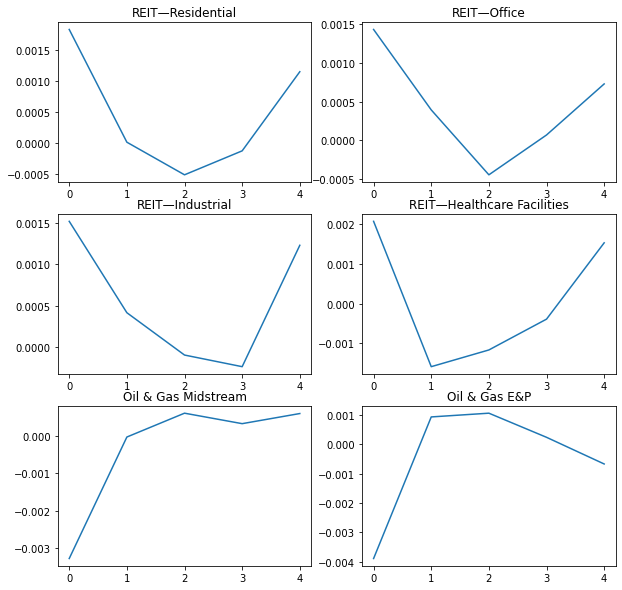

In [126]:
sigDifIndust = ["REIT—Residential", "REIT—Office", "REIT—Industrial", "REIT—Healthcare Facilities", "Oil & Gas Midstream", "Oil & Gas E&P"]

fig, ax = plt.subplots(len(sigDifIndust)//2, 2, figsize=(10,10))
plt.title("Average Returns by Day by Industry")

## Write a for loop
for i in range(len(sigDifIndust)):
    ind = np.argwhere(industries==sigDifIndust[i])[0][0]
    x = (i)//2
    y = (i) %2
    ax[x,y].plot(range(0, 5), np.mean(meanByDayIndustry[ind], axis = 1))
    ax[x,y].set_title(sigDifIndust[i])

For Oil & Gas E&P and Oil & Gas Midstream, the average returns on Monday are significantly lower, indicating a possible Monday effect in these industries. As these industires are very closely related, it is no suprised that the stock return patterns are similar for these two industries. When considering the industries as a whole, the stock reutnrs on Monday were the highest. Therefore, there isn't a consistent pattern across industries. 

In [127]:
# Let's look at the proportion of industries that showed Monday effect
len(sigDifIndust)/len(industries)

0.05172413793103448

Only around 5% of the industries had Monday stock returns to be significantly different from other days of the week. Given that we have chosen our type-I error rate to be .05, this number is not suprising. 

Well, when examined across months and industries, the overall average stock returns of S&P 500 constituents in 2017 were the lowest. However, when divided into months and industries, the pattern of stock returns varied. 

Before you put a pin on our findings, let's see if the results will be replicated for the S&P 500 constituents in 2021. 

### Creating a dataframe of stock returns for the latest S&P 500 constituents  <a clas ="anchor" id = "1_2021"></a>
The list of constituents for the latest S&P500 are available in `list of sp500.xlsx` file. 

In [25]:
SP500list = pd.read_excel('list of sp500.xlsx', engine='openpyxl')
SP_ticker_2020 = SP500list['Symbol'].tolist()

#### Obtaining the stock data of latest S&P 500 constituents

In [55]:
# Using the ticker to obtain stock prices from yfinance
rawdata = yf.download(SP_ticker_2020, start="2017-12-30", end="2021-05-28")
rawdata.columns = rawdata.columns.set_names(['Value', 'Symbol'])
rawdata.head()

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


Value       Adj Close                                                          \
Symbol              A        AAL         AAP       AAPL       ABBV        ABC   
Date                                                                            
2018-01-02  65.777748  51.647556  104.796822  41.310070  81.751373  88.406036   
2018-01-03  67.451401  51.014027  105.745117  41.302879  83.030678  88.735046   
2018-01-04  66.945419  51.335667  109.646957  41.494736  82.557167  88.537621   
2018-01-05  68.015762  51.316177  110.812576  41.967163  83.994331  89.609322   
2018-01-08  68.161713  50.809345  110.032219  41.811283  82.648544  91.094681   

Value                                                      ...     Volume  \
Symbol            ABMD        ABT         ACN        ADBE  ...        XEL   
Date                                                       ...              
2018-01-02  192.490005  55.480598  145.921112  177.699997  ...  2443400.0   
2018-01-03  195.820007  55.603271  146.594574  181.039993  ...  4114900.0   
2018-01-04  199.250000  55.508900  148.330338  183.220001  ...  2807000.0   
2018-01-05  202.320007  55.669323  149.553955  185.339996  ...  3728000.0   
2018-01-08  207.800003  55.508900  150.749115  185.039993  ...  3837600.0   

Value                                                                         \
Symbol           XLNX         XOM       XRAY       XYL        YUM        ZBH   
Date                                                                           
2018-01-02  2579900.0  11469300.0  1622300.0  877800.0  1747800.0  1765300.0   
2018-01-03  2453300.0  13957700.0  1533300.0  778800.0  2554900.0  1328800.0   
2018-01-04  3346500.0  10863000.0  1052400.0  796500.0  1971200.0  1073200.0   
2018-01-05  5683500.0  11047600.0  1329000.0  666800.0  1927100.0  1063400.0   
2018-01-08  2483100.0  10927100.0  1188500.0  554700.0  1599400.0  1249500.0   

Value                                       
Symbol          ZBRA       ZION        ZTS  
Date                                        
2018-01-02  310600.0  2387100.0  2135600.0  
2018-01-03  253000.0  1575700.0  2328200.0  
2018-01-04  435200.0  3309200.0  2534000.0  
2018-01-05  301800.0  1212200.0  2166100.0  
2018-01-08  218600.0  1697700.0  3631400.0  

[5 rows x 3030 columns]

#### Deleting the missing values

In [56]:
# Inspecting the missing values in terms of rows
rawdata['Close'].isna().sum(axis=0).describe()

count    505.000000
mean      10.089109
std       69.683397
min        2.000000
25%        2.000000
50%        2.000000
75%        2.000000
max      859.000000
dtype: float64

In [57]:
# Making an list of tuples for tickers that has more than 3 missing values
high_missing_ticker = rawdata['Close'].isna().sum(axis=0) > 3
high_missing_ticker_list = high_missing_ticker[high_missing_ticker].index.tolist()
high_missing_ticker_tuples = list()
for i in ['Adj Close', 'Open', 'Close', 'High' ,'Low', 'Volume']:
    high_missing_ticker_tuples += list(zip([i]*len(high_missing_ticker_list),high_missing_ticker_list))

In [58]:
# Excluding columns (i.e., tickers) that has more than 3 missing values 
rawdata = rawdata.drop(high_missing_ticker_tuples, axis = 1)

In [59]:
# Finding out the dates that all tickers (columns) have missing values
missingdate =rawdata.isna().sum(axis=1) > 0
missingdate[missingdate].index

DatetimeIndex(['2018-12-05', '2021-05-28'], dtype='datetime64[ns]', name='Date', freq=None)

In [60]:
# delete the first row if it has missing values
if rawdata.iloc[0].isna().sum().any():
    rawdata = rawdata.iloc[1:]

In [61]:
# other rows with missing values are replaced with the values from the previous date
rawdata = rawdata.fillna(method= 'ffill')

In [62]:
# Double check to see if all the missing values were either removed or replaced
(rawdata.isna().sum(axis=None)>0).any()

False

#### Calculating the log returns for closing price

In [63]:
# Getting the log returns from stock prices
logret = np.log(rawdata['Close']).diff()
logret.columns = pd.MultiIndex.from_product([['logreturn'], logret.columns])
# Joining logret and rawdata 
rawdata = rawdata.join(logret)

In [64]:
print("After preprocessing the data, we have idenified the log returns of {} companies, which were included in S&P500 in 2021. To recap, we are examining the stock returns from 2018 to May 2021. Therefore, we will be examining the stock returns of {} days".format(len(logret.columns), len(logret)))

After preprocessing the data, we have idenified the log returns of 496 companies, which were included in S&P500 in 2021. To recap, we are examining the stock returns from 2018 to May 2021. Therefore, we will be examining the stock returns of 859 days


#### Creating a new columns for the industry information

In [65]:
# Obtaining the information about the tickers that are included in SP_ticker_2017
industry_dic = dict()
for item in SP_ticker_2020:
    try:
        industry_dic[item] = yf.Ticker(item).info['industry']
    except:
        industry_dic[item] = None

In [66]:
# Adding the industry to a level of the column
rawdata.columns = pd.MultiIndex.from_tuples([(value, industry_dic[ticker], ticker) for value, ticker in rawdata.columns])
rawdata = rawdata.drop(pd.Timestamp('2018-01-02'))
rawdata.head()

Adj Close                              \
           Diagnostics & Research   Airlines Specialty Retail   
                                A        AAL              AAP   
Date                                                            
2018-01-02              65.777748  51.647556       104.796822   
2018-01-03              67.451401  51.014027       105.745117   
2018-01-04              66.945419  51.335667       109.646957   
2018-01-05              68.015762  51.316177       110.812576   
2018-01-08              68.161713  50.809345       110.032219   

                                                            \
           Consumer Electronics Drug Manufacturers—General   
                           AAPL                       ABBV   
Date                                                         
2018-01-02            41.310070                  81.751373   
2018-01-03            41.302879                  83.030678   
2018-01-04            41.494736                  82.557167   
2018-01-05            41.967163                  83.994331   
2018-01-08            41.811283                  82.648544   

                                                            \
           Medical Distribution Medical Devices              
                            ABC            ABMD        ABT   
Date                                                         
2018-01-02            88.406036      192.490005  55.480598   
2018-01-03            88.735046      195.820007  55.603271   
2018-01-04            88.537621      199.250000  55.508900   
2018-01-05            89.609322      202.320007  55.669323   
2018-01-08            91.094681      207.800003  55.508900   

                                                                    ...  \
           Information Technology Services Software—Infrastructure  ...   
                                       ACN                    ADBE  ...   
Date                                                                ...   
2018-01-02                      145.921112              177.699997  ...   
2018-01-03                      146.594574              181.039993  ...   
2018-01-04                      148.330338              183.220001  ...   
2018-01-05                      149.553955              185.339996  ...   
2018-01-08                      150.749115              185.039993  ...   

                              logreturn                                      \
           Utilities—Regulated Electric Semiconductors Oil & Gas Integrated   
                                    XEL           XLNX                  XOM   
Date                                                                          
2018-01-02                          NaN            NaN                  NaN   
2018-01-03                    -0.006716       0.019837             0.019450   
2018-01-04                    -0.007822       0.017892             0.001383   
2018-01-05                    -0.007028       0.050619            -0.000807   
2018-01-08                     0.007452       0.006586             0.004486   

                                                                          \
           Medical Instruments & Supplies Specialty Industrial Machinery   
                                     XRAY                            XYL   
Date                                                                       
2018-01-02                            NaN                            NaN   
2018-01-03                      -0.003431                       0.012120   
2018-01-04                      -0.000149                       0.006654   
2018-01-05                       0.013953                      -0.001876   
2018-01-08                       0.006758                       0.003605   

                                                                               \
           Restaurants Medical Devices Communication Equipment Banks—Regional   
                   YUM             ZBH                    ZBRA           ZION   
Date

In [69]:
rawdata.head()

Adj Close                              \
           Diagnostics & Research   Airlines Specialty Retail   
                                A        AAL              AAP   
Date                                                            
2018-01-03              67.451401  51.014027       105.745117   
2018-01-04              66.945419  51.335667       109.646957   
2018-01-05              68.015762  51.316177       110.812576   
2018-01-08              68.161713  50.809345       110.032219   
2018-01-09              69.835342  50.760616       109.143166   

                                                            \
           Consumer Electronics Drug Manufacturers—General   
                           AAPL                       ABBV   
Date                                                         
2018-01-03            41.302879                  83.030678   
2018-01-04            41.494736                  82.557167   
2018-01-05            41.967163                  83.994331   
2018-01-08            41.811283                  82.648544   
2018-01-09            41.806496                  83.271591   

                                                            \
           Medical Distribution Medical Devices              
                            ABC            ABMD        ABT   
Date                                                         
2018-01-03            88.735046      195.820007  55.603271   
2018-01-04            88.537621      199.250000  55.508900   
2018-01-05            89.609322      202.320007  55.669323   
2018-01-08            91.094681      207.800003  55.508900   
2018-01-09            91.677536      209.759995  55.603271   

                                                                    ...  \
           Information Technology Services Software—Infrastructure  ...   
                                       ACN                    ADBE  ...   
Date                                                                ...   
2018-01-03                      146.594574              181.039993  ...   
2018-01-04                      148.330338              183.220001  ...   
2018-01-05                      149.553955              185.339996  ...   
2018-01-08                      150.749115              185.039993  ...   
2018-01-09                      151.251831              186.699997  ...   

                logreturn                                                      \
           Semiconductors Oil & Gas Integrated Medical Instruments & Supplies   
                     XLNX                  XOM                           XRAY   
Date                                                                            
2018-01-03       0.019837             0.019450                      -0.003431   
2018-01-04       0.017892             0.001383                      -0.000149   
2018-01-05       0.050619            -0.000807                       0.013953   
2018-01-08       0.006586             0.004486                       0.006758   
2018-01-09       0.002676            -0.004255                      -0.042623   

                                                                       \
           Specialty Industrial Machinery Restaurants Medical Devices   
                                      XYL         YUM             ZBH   
Date                                                                    
2018-01-03                       0.012120   -0.000858        0.006908   
2018-01-04                       0.006654    0.010129       -0.001442   
2018-01-05                      -0.001876    0.005811        0.009892   
2018-01-08                       0.003605    0.001689        0.001903   
2018-01-09                       0.000288   -0.002655       -0.016214   

                                                   \
           Communication Equipment Banks—Regional   
                              ZBRA           ZION   
Date                                                
2018-01-03                0.019668      -0.0

#### Creating a new columns for days of the week

In [67]:
# The day of the week is added as a new index (creating a hierarchical index)
rawdata['days'] = [calendar.day_name[day.weekday()] for day in rawdata.index]

#### Exporting dataframe as csv

In [70]:
rawdata.to_csv('SP500_2018_2021_multilevel.csv')

#### Staking the Closing and Log returns into one dataframe

For convenience in running some of the statistical analyses, the multilevel data of stock values are stacked into a dataframe. 

In [71]:
# To easily stack the data, it is easier to delete the days and industry information.
rawdata = rawdata.drop('days', axis =1)
rawdata.columns = rawdata.columns.droplevel(1)

In [72]:
# The data is stacked 
stacked_rawdata = rawdata.stack()
stacked_rawdata.reset_index(inplace=True)
stacked_rawdata = stacked_rawdata.rename(columns = {'level_1':'Ticker'})

# Days are added as a new column
stacked_rawdata['days'] = [calendar.day_name[day.weekday()] for day in stacked_rawdata['Date']]

# Industry information is added as a new column
stacked_rawdata['Industry'] = [industry_dic[ticker] for ticker in stacked_rawdata['Ticker']]
stacked_rawdata.head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,logreturn,days,Industry
0,2018-01-03,A,67.451401,69.320000,69.489998,67.599998,67.620003,1698900.0,0.025125,Wednesday,Diagnostics & Research
1,2018-01-03,AAL,51.014027,52.340000,52.860001,52.060001,52.860001,5074900.0,-0.012342,Wednesday,Airlines
2,2018-01-03,AAP,105.745117,107.050003,107.660004,105.300003,106.419998,2086800.0,0.009008,Wednesday,Specialty Retail
3,2018-01-03,AAPL,41.302879,43.057499,43.637501,42.990002,43.132500,118071600.0,-0.000174,Wednesday,Consumer Electronics
4,2018-01-03,ABBV,83.030678,99.949997,100.099998,98.040001,98.550003,4702300.0,0.015528,Wednesday,Drug Manufacturers—General


In [ ]:
# Before we forget, let's add the days and industry column back to our rawdata. We will comeback to this later
stacked_rawdata.columns = pd.MultiIndex.from_tuples([(value, industry_dic[ticker], ticker) for value, ticker in stacked_rawdata.columns])
stacked_rawdata['days'] = [calendar.day_name[day.weekday()] for day in rawdata.index]


#### Exporting dataframe as csv

In [73]:
stacked_rawdata.to_csv('SP500_2018_2021_stacked.csv')

### Analyzing the Monday Effect
The next step is to analyze the Monday effect. This process will be very similar to that for S&P 500 constituents in 2017. 

In [76]:
# We will the log returns of the constituents and dropping the industry level
multilevel = pd.read_csv('SP500_2018_2021_multilevel.csv', header=[0,1,2], index_col=0)
logret = multilevel['logreturn'].droplevel(0, axis =1)
logret.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,0.025125,-0.012342,0.009008,-0.000174,0.015528,0.003715,0.017152,0.002209,0.004605,0.018621,...,-0.006716,0.019837,0.019450,-0.003431,0.012120,-0.000858,0.006908,0.019668,-0.001184,0.004588
2018-01-04,-0.007530,0.006285,0.036234,0.004634,-0.005719,-0.002227,0.017364,-0.001699,0.011771,0.011970,...,-0.007822,0.017892,0.001383,-0.000149,0.006654,0.010129,-0.001442,0.019567,0.004138,0.005946
2018-01-05,0.015862,-0.000380,0.010575,0.011321,0.017258,0.012032,0.015290,0.002886,0.008215,0.011504,...,-0.007028,0.050619,-0.000807,0.013953,-0.001876,0.005811,0.009892,0.015456,0.000393,0.011379
2018-01-08,0.002144,-0.009926,-0.007067,-0.003721,-0.016152,0.016440,0.026725,-0.002886,0.007960,-0.001620,...,0.007452,0.006586,0.004486,0.006758,0.003605,0.001689,0.001903,0.009901,-0.004927,0.011924
2018-01-09,0.024257,-0.000960,-0.008113,-0.000115,0.007510,0.006378,0.009388,0.001699,0.003329,0.008931,...,-0.011736,0.002676,-0.004255,-0.042623,0.000288,-0.002655,-0.016214,0.030183,0.023236,0.011651


In [1]:
# Let's plotthe average returms
np.mean(logret, axis = 1).plot()
plt.title("Average Return For All S&P500 Companies By Day for 2018-2021")
plt.show()

NameError: name 'np' is not defined

In [130]:
# As we have imported the data again, we have to specify that our index is in datetime
logret.index = pd.to_datetime(logret.index)
# Let's retrieve the day of the week as the index and drop other columns that are not log returns
logret['Day of Week'] = logret.index.dayofweek
groupeddata = logret.groupby('Day of Week')
mean_per_stock = groupeddata.mean()
mean_per_stock.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Day of Week,,,,,,,,,,,,,,,,,,,,,
0,-0.000720,-0.000307,0.001063,0.002819,-0.000069,0.000609,-0.002944,-0.001274,-0.000840,-0.000906,...,-0.000135,-0.000190,0.000839,0.001609,-0.000277,-0.001307,-0.001686,-0.000469,0.001801,-0.001011
1,0.000621,0.000145,0.002899,0.002038,-0.001745,-0.000097,0.002834,0.000324,0.001179,0.002763,...,0.001144,0.002270,-0.000373,-0.001679,0.001009,0.001456,0.000644,0.006312,-0.001593,0.002565
2,0.000531,0.000530,0.000113,0.002959,0.000829,0.000839,0.000623,0.001618,0.000213,0.001924,...,-0.000274,-0.001252,0.000075,-0.000051,0.000467,0.000667,0.000826,0.001006,-0.000587,-0.000409
3,0.001845,-0.003127,0.000401,-0.000048,-0.000947,-0.000500,-0.000005,0.002051,0.001659,0.001718,...,0.001086,0.002439,-0.001495,-0.002108,-0.000853,0.001341,-0.000016,0.000227,0.000273,0.002228
4,0.001784,-0.001745,-0.001138,-0.001508,0.002739,0.000346,0.001586,0.001098,0.001191,0.000348,...,0.000385,0.000134,-0.001153,0.002324,0.002818,-0.000032,0.001878,0.001904,0.001011,0.001691


#### Descriptive Analaysis
Let's start with the basic descriptive statistics. Here are the mean log returns across all the stocks returns for each days of the week.\
0 indicates Monday, 2 Tuesday, 3 Wednesday, 4 Thursday, 5 Friday

In [131]:
np.mean(mean_per_stock, axis = 1)

Day of Week
0   -0.000022
1    0.001108
2    0.000064
3   -0.000048
4    0.001070
dtype: float64

When we look at the mean, it seems as if the average stock returns from 2018 to 2021 across companies is negative on Monday. However, it is not the lowest. Let's visualize this.

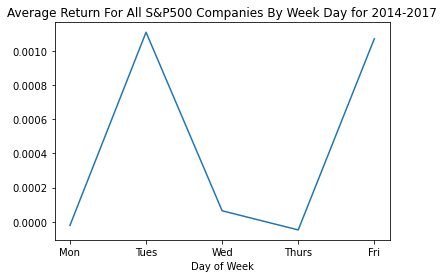

In [132]:
# Let's plot them to clearly see the difference
np.mean(mean_per_stock, axis = 1).plot()
plt.title("Average Return For All S&P500 Companies By Week Day for 2018-2021")
plt.xticks([0, 1, 2, 3, 4], ["Mon", "Tues", "Wed", "Thurs", "Fri"], rotation='horizontal')
plt.show()

#### ANOVA

In [133]:
# let's conduct a oneway ANOVA on the five days of the week
fval, pval = stats.f_oneway(np.array(mean_per_stock.iloc[0].array), np.array(mean_per_stock.iloc[1].array), np.array(mean_per_stock.iloc[2].array), np.array(mean_per_stock.iloc[3].array), np.array(mean_per_stock.iloc[4].array))
print("F = {}, p = {}".format(fval,pval))

F = 86.70462397823987, p = 5.168894125059019e-69


The ANOVA results indicate that the average stock returns across days are significantly different across the board. Next, we will conduct a pairwise comparison to examine which days are significantly different from each other.

In [134]:
# We will conduct pair-wise comparison
dfTukey = pd.DataFrame({'return': np.reshape(mean_per_stock.values, -1),
                   'day': np.repeat(mean_per_stock.index, repeats=len(mean_per_stock.iloc[1,:]))})

tukey = pairwise_tukeyhsd(endog=dfTukey["return"], groups = dfTukey["day"], alpha = 0.05)

print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.0011  0.001  0.0009  0.0014   True
     0      2   0.0001 0.8718 -0.0002  0.0003  False
     0      3     -0.0    0.9 -0.0003  0.0002  False
     0      4   0.0011  0.001  0.0008  0.0013   True
     1      2   -0.001  0.001 -0.0013 -0.0008   True
     1      3  -0.0012  0.001 -0.0014 -0.0009   True
     1      4     -0.0    0.9 -0.0003  0.0002  False
     2      3  -0.0001  0.707 -0.0004  0.0001  False
     2      4    0.001  0.001  0.0008  0.0013   True
     3      4   0.0011  0.001  0.0009  0.0014   True
----------------------------------------------------


Unlike the data for S&P 500 constituents for 2017, there results do not indicate that Monday stock returns are significantly lower than all the other days of the week. As Monday effect is not supported by the data for the latest S&P500, we will refrain from analyzing the effect by month and industry.

----------

## Tackling Objective 2  <a clas ="anchor" id = "tackling-objective-2"></a>

In this section, we will examine Monday effect in term of its second defintion. We will use the same data that were used in the previous section. 

Disclaimer: did you know that you can run R codes in a python based jupyter notebook? Well, the environment that this notebook is built on allows for that with the use of [rpy2](https://pypi.org/project/rpy2/) package. We simply use `%%R` in the cell that we want to run R codes. `%%R` is called R magic (and yes, magic indeed). 

### Setting up R and Importing R libraries

In [7]:
#Let's import rpy2
import rpy2
#The following code enables you to use R magic
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
%%R
#Let's load the R packages that we will use, we will use `pacman` library to help us load all other libraries 
install.packages("pacman")
library(pacman)
p_load(dplyr, plyr, readr, tidyr, reshape, ggplot2, sjPlot)

R[write to console]: Warning:
R[write to console]:  package 'pacman' is in use and will not be installed



### Importing the data for S&P 500 constituents in 2017 <a clas ="anchor" id = "2_2017"></a>

In [77]:
%%R
#Let's read in the .csv file of the stock returns for S&P 500 constituents in 2017
SP500_2014_2017_stacked <- read_csv("SP500_2014_2017_stacked.csv")

#We will sort the dataset by company (i.e. tickers)
all_data <- SP500_2014_2017_stacked[order(SP500_2014_2017_stacked$Ticker),]

#The numeric date will be used as an index to pair log returns of two consecutive days
Date_num = as.numeric(all_data$Date)
all_data["Date_num"]=Date_num 

#Before we move on, let's clean the data by removing the date variable
all_data_no_date = subset(all_data, select = -Date)

# Let's generate a list of unique companies (i.e. unique tickers)
Ticker_list = unique(all_data_no_date$Ticker)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  X1 = col_double(),
  Date = col_date(format = ""),
  Ticker = col_character(),
  `Adj Close` = col_double(),
  Close = col_double(),
  High = col_double(),
  Low = col_double(),
  Open = col_double(),
  Volume = col_double(),
  logreturn = col_double(),
  days = col_character(),
  Industry = col_character()
)



### Seperating the dataset based on the days of the week <a clas ="anchor" id = "seperating"></a>

In [78]:
%%R
#We wil now make pairs of log-return for two consecutive days
Monday = Tuesday = Wednesday = Thursday = Friday = Next_Monday = {}

for (ticker in Ticker_list){
  Company_temp = {}
  Monday_temp = {}
  # Let's take one company at a time
  Company_temp = filter(all_data_no_date,Ticker == ticker)
  # We will use Monday as the benchmark for finding pairs
  Monday_temp = filter(Company_temp,days == "Monday")
  Monday = rbind(Monday, Monday_temp)
  
  for (date in Monday_temp$Date_num){
    #Friday is 4 days after Monday
    Friday_temp =  subset(Company_temp, Date_num == (date+4))
    #If there is no data for the following Friday, set as NA
    if(dim(Friday_temp)[1] == 0){Friday_temp = NA}
    Friday = rbind(Friday,Friday_temp)
    #We will repeat this for all other days of the week
    Thursday_temp = subset(Company_temp, Date_num == (date+3))
    if(dim(Thursday_temp)[1] == 0){Thursday_temp = NA}
    Thursday = rbind(Thursday,Thursday_temp)
    
    Wednesday_temp = subset(Company_temp, Date_num == (date+2))
    if(dim(Wednesday_temp)[1] == 0){Wednesday_temp = NA}
    Wednesday = rbind(Wednesday,Wednesday_temp)
    
    Tuesday_temp = subset(Company_temp, Date_num == (date+1))
    if(dim(Tuesday_temp)[1] == 0){Tuesday_temp = NA}
    Tuesday = rbind(Tuesday,Tuesday_temp)
    
    Next_Monday_temp = subset(Company_temp, Date_num == (date+7))
    if(dim(Next_Monday_temp)[1] == 0){Next_Monday_temp = NA}
    Next_Monday = rbind(Next_Monday,Next_Monday_temp)
  }
}

#Let's save the data sets for each days of the week to .csv files
write.csv(Monday,"Monday2017.csv", row.names = FALSE)
write.csv(Tuesday,"Tuesday2017.csv", row.names = FALSE)
write.csv(Wednesday,"Wednesday2017.csv", row.names = FALSE)
write.csv(Thursday,"Thursday2017.csv", row.names = FALSE)
write.csv(Friday,"Friday2017.csv", row.names = FALSE)
write.csv(Next_Monday,"Next_Monday2017.csv", row.names = FALSE)

R[write to console]: Error in rbind(deparse.level, ...) : 
  numbers of columns of arguments do not match

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Missing column names filled in: 'X1' [1] 




Error in rbind(deparse.level, ...) : 
  numbers of columns of arguments do not match


RInterpreterError: Failed to parse and evaluate line '#We wil now make pairs of log-return for two consecutive days\nMonday = Tuesday = Wednesday = Thursday = Friday = Next_Monday = {}\n\nfor (ticker in Ticker_list){\n  Company_temp = {}\n  Monday_temp = {}\n  # Let\'s take one company at a time\n  Company_temp = filter(all_data_no_date,Ticker == ticker)\n  # We will use Monday as the benchmark for finding pairs\n  Monday_temp = filter(Company_temp,days == "Monday")\n  Monday = rbind(Monday, Monday_temp)\n  \n  for (date in Monday_temp$Date_num){\n    #Friday is 4 days after Monday\n    Friday_temp =  subset(Company_temp, Date_num == (date+4))\n    #If there is no data for the following Friday, set as NA\n    if(dim(Friday_temp)[1] == 0){Friday_temp = NA}\n    Friday = rbind(Friday,Friday_temp)\n    #We will repeat this for all other days of the week\n    Thursday_temp = subset(Company_temp, Date_num == (date+3))\n    if(dim(Thursday_temp)[1] == 0){Thursday_temp = NA}\n    Thursday = rbind(Thursday,Thursday_temp)\n    \n    Wednesday_temp = subset(Company_temp, Date_num == (date+2))\n    if(dim(Wednesday_temp)[1] == 0){Wednesday_temp = NA}\n    Wednesday = rbind(Wednesday,Wednesday_temp)\n    \n    Tuesday_temp = subset(Company_temp, Date_num == (date+1))\n    if(dim(Tuesday_temp)[1] == 0){Tuesday_temp = NA}\n    Tuesday = rbind(Tuesday,Tuesday_temp)\n    \n    Next_Monday_temp = subset(Company_temp, Date_num == (date+7))\n    if(dim(Next_Monday_temp)[1] == 0){Next_Monday_temp = NA}\n    Next_Monday = rbind(Next_Monday,Next_Monday_temp)\n  }\n}\n\n#Let\'s save the data sets for each days of the week to .csv files\nwrite.csv(Monday,"Monday2017.csv", row.names = FALSE)\nwrite.csv(Tuesday,"Tuesday2017.csv", row.names = FALSE)\nwrite.csv(Wednesday,"Wednesday2017.csv", row.names = FALSE)\nwrite.csv(Thursday,"Thursday2017.csv", row.names = FALSE)\nwrite.csv(Friday,"Friday2017.csv", row.names = FALSE)\nwrite.csv(Next_Monday,"Next_Monday2017.csv", row.names = FALSE)\n'.
R error message: 'Error in rbind(deparse.level, ...) : \n  numbers of columns of arguments do not match'

### Reading in the datasets for each days of the week

In [11]:
%%R
#
Monday = read_csv("Monday2017.csv")
Tuesday = read_csv("Tuesday2017.csv")
Wednesday = read_csv("Wednesday2017.csv")
Thursday = read_csv("Thursday2017.csv")
Friday = read_csv("Friday2017.csv")
Next_Monday = read_csv("Next_Monday2017.csv")

Monday['Index']= 1:nrow(Monday)
Tuesday['Index']= 1:nrow(Tuesday)
Wednesday['Index']= 1:nrow(Wednesday)
Thursday['Index']= 1:nrow(Thursday)
Friday['Index']= 1:nrow(Friday)
Next_Monday['Index']= 1:nrow(Next_Monday)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  X1 = col_double(),
  Ticker = col_character(),
  `Adj Close` = col_double(),
  Close = col_double(),
  High = col_double(),
  Low = col_double(),
  Open = col_double(),
  Volume = col_double(),
  logreturn = col_double(),
  days = col_character(),
  Industry = col_character(),
  Date_num = col_double()
)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  X1 = col_double(),
  Ticker = col_character(),
  `Adj Close` = col_double(),
  Close = col_double(),
  High = col_double(),
  Low = col_double(),
  Open = col_double(),
  Volume = col_double(),
  logreturn = col_double(),
  days = col_character(),
  Industry = col_character(),
  Date_num = col_double()
)


-- Column specification ------------------------------------------------------------------------------------------------
cols

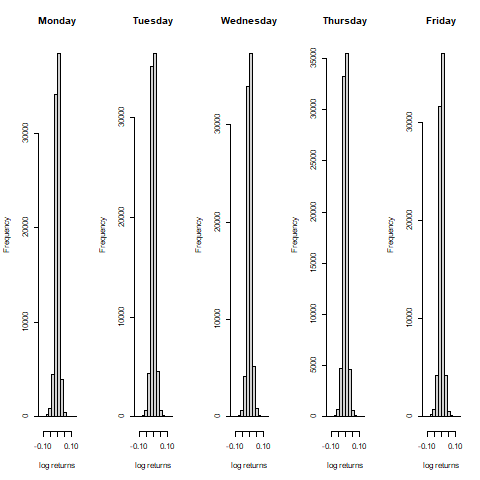

In [12]:
%%R
#histogram of log-return on each day
par(mfrow=c(1,5))
hist(Monday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Monday", xlab = 'log returns')
hist(Tuesday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Tuesday", xlab = 'log returns')
hist(Wednesday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Wednesday", xlab = 'log returns')
hist(Thursday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Thursday", xlab = 'log returns')
hist(Friday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Friday", xlab = 'log returns')

The histograms illustrate the frequency distribution of the log returns for each days of the week. Does this sound familiar? Yes, this is related to the first definition of Monday returns. By looking at the distribution, the log returns are close to zero for all days of the week. In fact, the number of days in which the log returns are slighly above zero is higher than thos slighly less than zero for all days of the week. Therefore, Monday effect in term of its first definition seems less promising. However, this section is related to the second definition of Monday effect. So, let's dive into examining the relationship between two consecutive days of the week. We will examine the linear regression on the pairs of consecutive days of the week.  

### Examining the relationship between the pairs of consecutive days of the week

In [13]:
%%R
# Let's look at the relationship between the log returns for pairs of consecutive days. A linear model is fit to the data.
fit_F_M = lm(Friday$logreturn~Next_Monday$logreturn)
fit_M_Tu = lm(Monday$logreturn~Tuesday$logreturn)
fit_Tu_W = lm(Tuesday$logreturn~Wednesday$logreturn)
fit_W_Th = lm(Wednesday$logreturn~Thursday$logreturn)
fit_Th_F = lm(Thursday$logreturn~Friday$logreturn)
tab_model(fit_F_M, fit_M_Tu, fit_Tu_W, fit_W_Th,fit_Th_F)

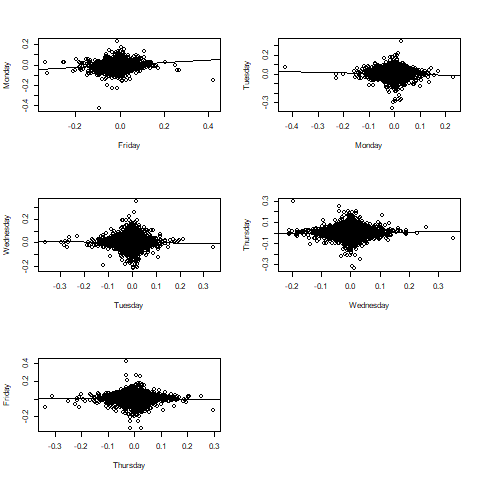

In [14]:
%%R
# Let's visualize our data. We will draw a scatter plot and the linear regression. 
layout(matrix(c(1,2,3,4,5,6), nrow = 3, ncol = 2, byrow = TRUE))
plot(Friday$logreturn,Next_Monday$logreturn,
    xlab = "Friday", ylab = "Monday")
abline(fit_F_M)
plot(Monday$logreturn,Tuesday$logreturn,
    xlab = "Monday", ylab = "Tuesday")
abline(fit_M_Tu)
plot(Tuesday$logreturn,Wednesday$logreturn,
    xlab = "Tuesday", ylab = "Wednesday")
abline(fit_Tu_W)
plot(Wednesday$logreturn,Thursday$logreturn,
    xlab = "Wednesday", ylab = "Thursday")
abline(fit_W_Th)
plot(Thursday$logreturn,Friday$logreturn,
    xlab = "Thursday", ylab = "Friday")
abline(fit_Th_F)
mtext("Linear relationship between two consecutive days", outer = TRUE, cex = 1.5)

There is a statistically significant relationship between all pairs of consecutive log returns. With this large sample size, a small relationship between the two values will be significant. Therefore, it is not encouraged to take the significance at the face value. We need to also consider the magnitude of the significance. The $R^2$ value indicates that around 0.8% of the variance in Monday returns are explained with the Friday returns. The $R^2$ for these two consecutive days are larger than all other pairs. 

In [15]:
%%R
# We will record the R-squared value and coefficents of this linear regression. This will be used later on to compare it to other days of the week.
fit_F_M_R2 = summary(fit_F_M)$r.squared
fit_M_Tu_R2 = summary(fit_M_Tu)$r.squared
fit_Tu_W_R2 = summary(fit_Tu_W)$r.squared
fit_W_Th_R2 = summary(fit_W_Th)$r.squared
fit_Th_F_R2 = summary(fit_Th_F)$r.squared
fit_F_M_Beta = fit_F_M$coef[2]
fit_M_Tu_Beta = fit_M_Tu$coef[2]
fit_Tu_W_Beta = fit_Tu_W$coef[2]
fit_W_Th_Beta = fit_W_Th$coef[2]
fit_Th_F_Beta = fit_Th_F$coef[2]
# Let's create a series that has R-squared values of linear models using all industries on each pair of days
r_before = c(fit_F_M_R2,fit_M_Tu_R2,fit_Tu_W_R2,fit_W_Th_R2,fit_Th_F_R2)
beta_before = c(fit_F_M_Beta, fit_M_Tu_Beta,fit_Tu_W_Beta, fit_W_Th_Beta, fit_Th_F_Beta)

### Examining the relationship between the pairs of consecutive days of the week for different industries

We just looked at the linear relationship between the pairs of consecutive days of the week across all S&P 500 constituents. However, it is possible for Monday effect to vary based on industries. In this sections, we will take a step further in examining Monday effect (don't forget that we are focusing on the second definition here) by analyzing how many industries show a significant relationship between consecutive days of the week.  

In [16]:
%%R
# To make things easier, we will create a function that will run linear models for each groups. In our case, the groups are the industries.
lm_by_group <- function(z) {
   model.fit <- data.frame(coef(summary(lm(y~x,data=z))))
   # The first row is the intercept and the second row is the slope
   model.fit$predictor <- rownames(model.fit)
   model.fit
}

# Let's create a linear model between Friday and the following Monday for each industry
lm_by_industry_M_F <- data.frame(group=Next_Monday$Industry,y=Next_Monday$logreturn,x=Friday$logreturn)
lm_by_industry_M_F = lm_by_industry_M_F %>% drop_na()
models_M_F <- ddply(lm_by_industry_M_F,"group",lm_by_group)


# Let's filter out the industries that do not have significant linear relationship
models_M_F_sig = filter(models_M_F, Pr...t.. <0.05)
industry_M_F_sig = unique(models_M_F_sig$group)

# Let's calculate the proportion of industries that showed a significant linear relatioship between Monday and Friday's log returns
M_F = sum(models_M_F$Pr...t..<0.05)/nrow(models_M_F)

# We will repeat what we did above for rest of the pairs of consecutive days
lm_by_industry_F_Th <- data.frame(group=Friday$Industry,y=Friday$logreturn,x=Thursday$logreturn)
lm_by_industry_F_Th = lm_by_industry_F_Th %>% drop_na()
models_F_Th <- ddply(lm_by_industry_F_Th,"group",lm_by_group)
F_Th = sum(models_F_Th$Pr...t..<0.05)/nrow(models_F_Th)
models_F_Th_sig = filter(models_F_Th, Pr...t.. <0.05)
industry_F_Th_sig = unique(models_F_Th_sig$group)


lm_by_industry_Th_W <- data.frame(group=Thursday$Industry,y=Thursday$logreturn,x=Wednesday$logreturn)
lm_by_industry_Th_W = lm_by_industry_Th_W %>% drop_na()
models_Th_W <- ddply(lm_by_industry_Th_W,"group",lm_by_group)
Th_W = sum(models_Th_W$Pr...t..<0.05)/nrow(models_Th_W)
models_Th_W_sig = filter(models_Th_W, Pr...t.. <0.05)
industry_Th_W_sig = unique(models_Th_W_sig$group)


lm_by_industry_W_Tu <- data.frame(group=Wednesday$Industry,y=Wednesday$logreturn,x=Tuesday$logreturn)
lm_by_industry_W_Tu = lm_by_industry_W_Tu %>% drop_na()
models_W_Tu <- ddply(lm_by_industry_W_Tu,"group",lm_by_group)
W_Tu = sum(models_W_Tu$Pr...t..<0.05)/nrow(models_W_Tu)
models_W_Tu_sig = filter(models_W_Tu, Pr...t.. <0.05)
industry_W_Tu_sig = unique(models_W_Tu_sig$group)


lm_by_industry_Tu_M <- data.frame(group=Tuesday$Industry,y=Tuesday$logreturn,x=Monday$logreturn)
lm_by_industry_Tu_M = lm_by_industry_Tu_M %>% drop_na()
models_Tu_M <- ddply(lm_by_industry_Tu_M,"group",lm_by_group)
Tu_M = sum(models_Tu_M$Pr...t..<0.05)/nrow(models_Tu_M)
models_Tu_M_sig = filter(models_Tu_M, Pr...t.. <0.05)
industry_Tu_M_sig = unique(models_Tu_M_sig$group)

#Let's compare the proportion of industries that showed signicant linear relationship between the consecutive day pairs
sig_est_perc = data.frame(M_F,F_Th,Th_W,W_Tu,Tu_M)
colnames(sig_est_perc) <- c("Monday & Friday","Friday & Thursday", "Thursday & Wednesday", "Wednesday & Tuesday", "Tuesday & Monday")
print(round(sig_est_perc,3), row.names = "Proportion of industries with significant relationships")

                                                        Monday & Friday
Proportion of industries with significant relationships           0.401
                                                        Friday & Thursday
Proportion of industries with significant relationships              0.19
                                                        Thursday & Wednesday
Proportion of industries with significant relationships                0.181
                                                        Wednesday & Tuesday
Proportion of industries with significant relationships               0.323
                                                        Tuesday & Monday
Proportion of industries with significant relationships            0.254


Compared to other pairs of consecutive days, Monday and Friday pair had the largest proportion (40.1%) of industries that had signiciant linear relationship between the log returns. This is twice as large as the proportion of industries for Thursday and Wednesday pair (18.1%). We just looked at the proprotion of the signiciant industries. To closely scrutinize Monday effect, we will investigate the $R^2$ and coefficients (i.e. slope). This will provide how much of the variance of the log returns for a given day is explained with that of the previous day and also the strength as well as the direction of the effect.

In [17]:
%%R
# Let's select the subset of the data which includes the industries that had signicant relatinoship bewteen the Monday and Friday log returns 
Monday_Friday_M = subset(Next_Monday,Industry %in% industry_M_F_sig)
Monday_Friday_F = subset(Friday,Index %in% Monday_Friday_M$Index)

# Let's run the linear model again
fit_F_M_sig = lm(Monday_Friday_F$logreturn~Monday_Friday_M$logreturn)

# We will repeat these two steps for the rest of the pairs
Monday_Tuesday_M = subset(Monday,Industry %in% industry_Tu_M_sig)
Monday_Tuesday_Tu = subset(Tuesday,Index %in% Monday_Tuesday_M$Index)
fit_M_Tu_sig = lm(Monday_Tuesday_M$logreturn~Monday_Tuesday_Tu$logreturn)


Tuesday_Wednesday_Tu = subset(Tuesday,Industry %in% industry_W_Tu_sig)
Tuesday_Wednesday_W = subset(Wednesday,Index %in% Tuesday_Wednesday_Tu$Index)
fit_Tu_W_sig = lm(Tuesday_Wednesday_Tu$logreturn~Tuesday_Wednesday_W$logreturn)

Wednesday_Thursday_W = subset(Wednesday,Industry %in% industry_Th_W_sig)
Wednesday_Thursday_Th = subset(Thursday,Index %in% Wednesday_Thursday_W$Index)
fit_W_Th_sig = lm(Wednesday_Thursday_W$logreturn~Wednesday_Thursday_Th$logreturn)

Thursday_Friday_Th = subset(Thursday,Industry %in% industry_F_Th_sig)
Thursday_Friday_F = subset(Friday,Index %in% Thursday_Friday_Th$Index)
fit_Th_F_sig = lm(Thursday_Friday_Th$logreturn~Thursday_Friday_F$logreturn)

# Let's look at the relationship between the log returns for pairs of consecutive days for these industries
tab_model(fit_F_M_sig, fit_M_Tu_sig, fit_Tu_W_sig, fit_W_Th_sig,fit_Th_F_sig)


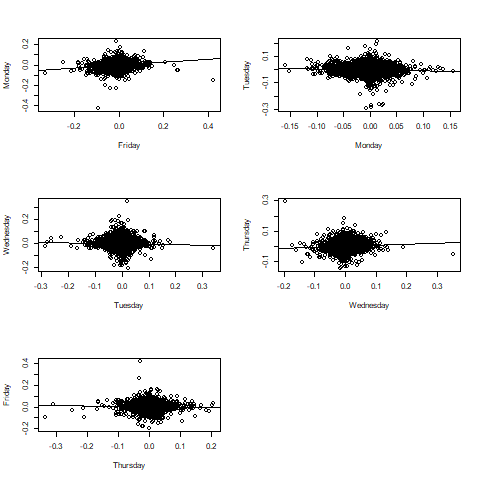

In [18]:
%%R
# Let's visualize our data. We will draw a scatter plot and the linear regression. 
layout(matrix(c(1,2,3,4,5,6), nrow = 3, ncol = 2, byrow = TRUE))
plot(Monday_Friday_F$logreturn,Monday_Friday_M$logreturn,
    xlab = "Friday", ylab = "Monday")
abline(fit_F_M_sig)
plot(Monday_Tuesday_M$logreturn,Monday_Tuesday_Tu$logreturn,
    xlab = "Monday", ylab = "Tuesday")
abline(fit_M_Tu_sig)
plot(Tuesday_Wednesday_Tu$logreturn,Tuesday_Wednesday_W$logreturn,
    xlab = "Tuesday", ylab = "Wednesday")
abline(fit_Tu_W_sig)
plot(Wednesday_Thursday_W$logreturn,Wednesday_Thursday_Th$logreturn,
    xlab = "Wednesday", ylab = "Thursday")
abline(fit_W_Th_sig)
plot(Thursday_Friday_Th$logreturn,Thursday_Friday_F$logreturn,
    xlab = "Thursday", ylab = "Friday")
abline(fit_Th_F_sig)

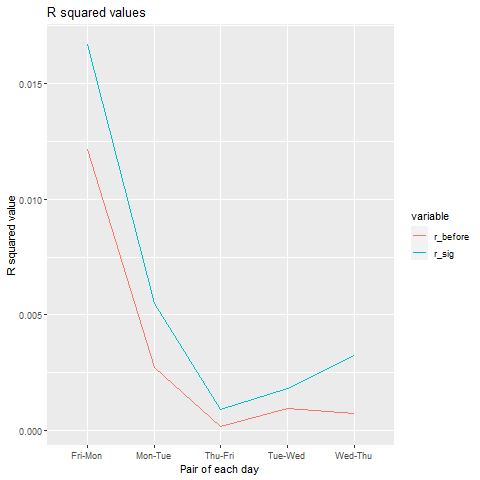

In [19]:
%%R
#We will also visualize the R-squared values and the coefficients for the pairs for the model that only includes the significant industries

#First, we need to save the R-squared values and the coefficents.
fit_F_M_sig_R2 = summary(fit_F_M_sig)$r.squared
fit_M_Tu_sig_R2 = summary(fit_M_Tu_sig)$r.squared
fit_Tu_W_sig_R2 = summary(fit_Tu_W_sig)$r.squared
fit_W_Th_sig_R2 = summary(fit_W_Th_sig)$r.squared
fit_Th_F_sig_R2 = summary(fit_Th_F_sig)$r.squared
fit_F_M_sig_Beta = fit_F_M_sig$coef[2]
fit_M_Tu_sig_Beta = fit_M_Tu_sig$coef[2]
fit_Tu_W_sig_Beta = fit_Tu_W_sig$coef[2]
fit_W_Th_sig_Beta = fit_W_Th_sig$coef[2]
fit_Th_F_sig_Beta = fit_Th_F_sig$coef[2]

# Let's store these values
r_sig = c(fit_F_M_sig_R2,fit_M_Tu_sig_R2,fit_Tu_W_sig_R2,fit_W_Th_sig_R2,fit_Th_F_sig_R2)
beta_sig = c(fit_F_M_sig_Beta,fit_M_Tu_sig_Beta,fit_Tu_W_sig_Beta,fit_W_Th_sig_Beta,fit_Th_F_sig_Beta)

# We will calculate how much the R-squared values and coefficients changed when using all the industries and only the significant industries
r_improve = (r_sig-r_before)/r_before
beta_improve = (beta_sig-beta_before)/beta_before

# Let's plot both R-squared values
names = c("Fri-Mon","Mon-Tue","Tue-Wed","Wed-Thu","Thu-Fri")
r_table =data.frame(names,r_before,r_sig)
r_melt <- melt(r_table, id = "names")
ggplot(data = r_melt) +
  geom_line(aes(x = names, y = value, colour = variable, group = variable))+ labs(x = "Pair of each day",y = "R squared value",title = "R squared values")

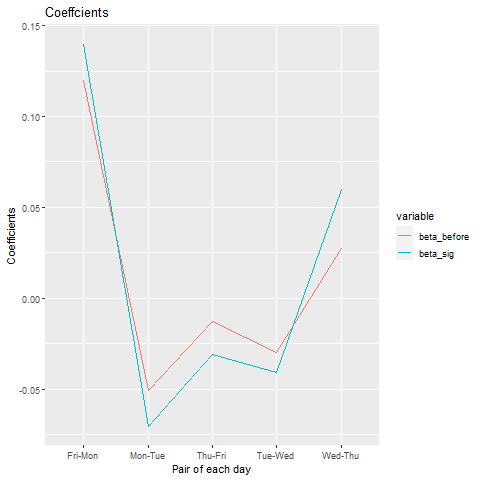

In [20]:
%%R
# Let's plot both coefficeitns
names = c("Fri-Mon","Mon-Tue","Tue-Wed","Wed-Thu","Thu-Fri")
beta_table =data.frame(names,beta_before,beta_sig)
beta_melt <- melt(beta_table, id = "names")
ggplot(data = beta_melt) +
  geom_line(aes(x = names, y = value, colour = variable, group = variable))+ labs(x = "Pair of each day",y = "Coefficients",title = "Coeffcients")

From the plot above, all the $R^2$ values are small, indicating that only very little of stock returns can be explained by the previous day's stock returns. However, the Friday-Monday linear relationship has a relatively higher R squared value than other pairs, suggesting that Monday's stock returns tends to be more sensitive to Friday's stock returns than any other pairs of consecutive two days. The unstandardized coefficient indicates that the relationship is positive.

The red line shows the R squared values and coefficients of linear models done on all industries while the blue line shows the R squared values and coefficients of linear models done on the industries that has the most significant linear relationships. The list of industries that have the most significant linear relationships is achieved by running linear models by industry and selecting those industries whose p-values are less than .05. The two lines has the same pattern: Friday-Monday has the most strongest relationship than any other pairs and the model performance enhanced with selected industries.

This observation from the 2014 to 2017 in the US market to some extent validates the second definition of Monday effect. We will now examine the second definition of Monday effect forthe S&P 500 constituents for 2021.

### Importing the data for S&P 500 constituents in 2021 <a clas ="anchor" id = "2_2021"></a>

We will omit repeating the [importing the data for S&P 500 constituents in 2017](#2_2017) and [seperating the dataset based on the days of the week](#seperating) to save some computational time. Instead, we will jump right into importing the log returns of S&P 500 constituents for 2021 which are seperated by the days of the week.  

In [83]:
%%R
Monday = read_csv("Monday2021.csv")
Tuesday = read_csv("Tuesday2021.csv")
Wednesday = read_csv("Wednesday2021.csv")
Thursday = read_csv("Thursday2021.csv")
Friday = read_csv("Friday2021.csv")
Next_Monday = read_csv("Next_Monday2021.csv")

Monday['Index']= 1:nrow(Monday)
Tuesday['Index']= 1:nrow(Tuesday)
Wednesday['Index']= 1:nrow(Wednesday)
Thursday['Index']= 1:nrow(Thursday)
Friday['Index']= 1:nrow(Friday)
Next_Monday['Index']= 1:nrow(Next_Monday)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  X1 = col_double(),
  Ticker = col_character(),
  `Adj Close` = col_double(),
  Close = col_double(),
  High = col_double(),
  Low = col_double(),
  Open = col_double(),
  Volume = col_double(),
  logreturn = col_double(),
  days = col_character(),
  Industry = col_character(),
  Date_num = col_double()
)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  X1 = col_double(),
  Ticker = col_character(),
  `Adj Close` = col_double(),
  Close = col_double(),
  High = col_double(),
  Low = col_double(),
  Open = col_double(),
  Volume = col_double(),
  logreturn = col_double(),
  days = col_character(),
  Industry = col_character(),
  Date_num = col_double()
)


-- Column specification ------------------------------------------------------------------------------------------------
cols

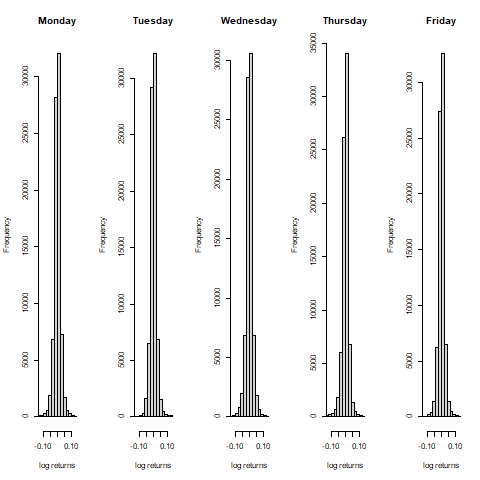

In [84]:
%%R
#histogram of log-return on each day
par(mfrow=c(1,5))
hist(Monday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Monday", xlab = 'log returns')
hist(Tuesday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Tuesday", xlab = 'log returns')
hist(Wednesday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Wednesday", xlab = 'log returns')
hist(Thursday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Thursday", xlab = 'log returns')
hist(Friday$logreturn,xlim = c(-0.12,0.12),breaks = 40, main = "Friday", xlab = 'log returns')

Similar to the historgams drawn for S&P500 for 20217 dataset, the log returns are close to zero for all days of the week.  In fact, the number of days in which the log returns are slighly above zero is higher than thos slighly less than zero for all days of the week.

### Examining the relationship between the pairs of consecutive days of the week

In [85]:
%%R
# Let's look at the relationship between the log returns for pairs of consecutive days. A linear model is fit to the data.
fit_F_M = lm(Friday$logreturn~Next_Monday$logreturn)
fit_M_Tu = lm(Monday$logreturn~Tuesday$logreturn)
fit_Tu_W = lm(Tuesday$logreturn~Wednesday$logreturn)
fit_W_Th = lm(Wednesday$logreturn~Thursday$logreturn)
fit_Th_F = lm(Thursday$logreturn~Friday$logreturn)
tab_model(fit_F_M, fit_M_Tu, fit_Tu_W, fit_W_Th,fit_Th_F)

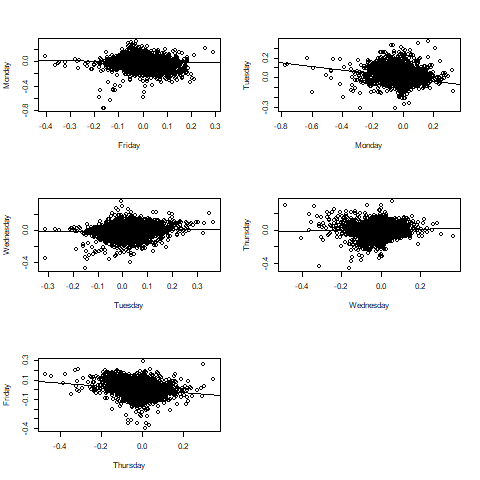

In [86]:
%%R
# Let's visualize our data. We will draw a scatter plot and the linear regression. 
layout(matrix(c(1,2,3,4,5,6), nrow = 3, ncol = 2, byrow = TRUE))
plot(Friday$logreturn,Next_Monday$logreturn,
    xlab = "Friday", ylab = "Monday")
abline(fit_F_M)
plot(Monday$logreturn,Tuesday$logreturn,
    xlab = "Monday", ylab = "Tuesday")
abline(fit_M_Tu)
plot(Tuesday$logreturn,Wednesday$logreturn,
    xlab = "Tuesday", ylab = "Wednesday")
abline(fit_Tu_W)
plot(Wednesday$logreturn,Thursday$logreturn,
    xlab = "Wednesday", ylab = "Thursday")
abline(fit_W_Th)
plot(Thursday$logreturn,Friday$logreturn,
    xlab = "Thursday", ylab = "Friday")
abline(fit_Th_F)
mtext("Linear relationship between two consecutive days", outer = TRUE, cex = 1.5)

As we have seen before, there is a statistically significant relationship between all pairs of consecutive log returns. With this large sample size, a small relationship between the two values will be significant. The largest $R^2$ value is 0.2% for Monday and Tuesday pair. Therefore, the results for S&P 500 for 2017 dataset did not replicate 

In [87]:
%%R
# We will record the R-squared value and coefficents of this linear regression. This will be used later on to compare it to other days of the week.
fit_F_M_R2 = summary(fit_F_M)$r.squared
fit_M_Tu_R2 = summary(fit_M_Tu)$r.squared
fit_Tu_W_R2 = summary(fit_Tu_W)$r.squared
fit_W_Th_R2 = summary(fit_W_Th)$r.squared
fit_Th_F_R2 = summary(fit_Th_F)$r.squared
fit_F_M_Beta = fit_F_M$coef[2]
fit_M_Tu_Beta = fit_M_Tu$coef[2]
fit_Tu_W_Beta = fit_Tu_W$coef[2]
fit_W_Th_Beta = fit_W_Th$coef[2]
fit_Th_F_Beta = fit_Th_F$coef[2]
# Let's create a series that has R-squared values of linear models using all industries on each pair of days
r_before = c(fit_F_M_R2,fit_M_Tu_R2,fit_Tu_W_R2,fit_W_Th_R2,fit_Th_F_R2)
beta_before = c(fit_F_M_Beta, fit_M_Tu_Beta,fit_Tu_W_Beta, fit_W_Th_Beta, fit_Th_F_Beta)

### Examining the relationship between the pairs of consecutive days of the week for different industries

We just looked at the linear relationship between the pairs of consecutive days of the week across all S&P 500 constituents. However, it is possible for Monday effect to vary based on industries. In this sections, we will take a step further in examining Monday effect (don't forget that we are focusing on the second definition here) by analyzing how many industries show a significant relationship between consecutive days of the week.  

In [88]:
%%R
# To make things easier, we will create a function that will run linear models for each groups. In our case, the groups are the industries.
lm_by_group <- function(z) {
   model.fit <- data.frame(coef(summary(lm(y~x,data=z))))
   # The first row is the intercept and the second row is the slope
   model.fit$predictor <- rownames(model.fit)
   model.fit
}

# Let's create a linear model between Friday and the following Monday for each industry
lm_by_industry_M_F <- data.frame(group=Next_Monday$Industry,y=Next_Monday$logreturn,x=Friday$logreturn)
lm_by_industry_M_F = lm_by_industry_M_F %>% drop_na()
models_M_F <- ddply(lm_by_industry_M_F,"group",lm_by_group)


# Let's filter out the industries that do not have significant linear relationship
models_M_F_sig = filter(models_M_F, Pr...t.. <0.05)
industry_M_F_sig = unique(models_M_F_sig$group)

# Let's calculate the proportion of industries that showed a significant linear relatioship between Monday and Friday's log returns
M_F = sum(models_M_F$Pr...t..<0.05)/nrow(models_M_F)

# We will repeat what we did above for rest of the pairs of consecutive days
lm_by_industry_F_Th <- data.frame(group=Friday$Industry,y=Friday$logreturn,x=Thursday$logreturn)
lm_by_industry_F_Th = lm_by_industry_F_Th %>% drop_na()
models_F_Th <- ddply(lm_by_industry_F_Th,"group",lm_by_group)
F_Th = sum(models_F_Th$Pr...t..<0.05)/nrow(models_F_Th)
models_F_Th_sig = filter(models_F_Th, Pr...t.. <0.05)
industry_F_Th_sig = unique(models_F_Th_sig$group)


lm_by_industry_Th_W <- data.frame(group=Thursday$Industry,y=Thursday$logreturn,x=Wednesday$logreturn)
lm_by_industry_Th_W = lm_by_industry_Th_W %>% drop_na()
models_Th_W <- ddply(lm_by_industry_Th_W,"group",lm_by_group)
Th_W = sum(models_Th_W$Pr...t..<0.05)/nrow(models_Th_W)
models_Th_W_sig = filter(models_Th_W, Pr...t.. <0.05)
industry_Th_W_sig = unique(models_Th_W_sig$group)


lm_by_industry_W_Tu <- data.frame(group=Wednesday$Industry,y=Wednesday$logreturn,x=Tuesday$logreturn)
lm_by_industry_W_Tu = lm_by_industry_W_Tu %>% drop_na()
models_W_Tu <- ddply(lm_by_industry_W_Tu,"group",lm_by_group)
W_Tu = sum(models_W_Tu$Pr...t..<0.05)/nrow(models_W_Tu)
models_W_Tu_sig = filter(models_W_Tu, Pr...t.. <0.05)
industry_W_Tu_sig = unique(models_W_Tu_sig$group)


lm_by_industry_Tu_M <- data.frame(group=Tuesday$Industry,y=Tuesday$logreturn,x=Monday$logreturn)
lm_by_industry_Tu_M = lm_by_industry_Tu_M %>% drop_na()
models_Tu_M <- ddply(lm_by_industry_Tu_M,"group",lm_by_group)
Tu_M = sum(models_Tu_M$Pr...t..<0.05)/nrow(models_Tu_M)
models_Tu_M_sig = filter(models_Tu_M, Pr...t.. <0.05)
industry_Tu_M_sig = unique(models_Tu_M_sig$group)

#Let's compare the proportion of industries that showed signicant linear relationship between the consecutive day pairs
sig_est_perc = data.frame(M_F,F_Th,Th_W,W_Tu,Tu_M)
colnames(sig_est_perc) <- c("Monday & Friday","Friday & Thursday", "Thursday & Wednesday", "Wednesday & Tuesday", "Tuesday & Monday")
print(round(sig_est_perc,3), row.names = "Proportion of industries with significant relationships")

                                                        Monday & Friday
Proportion of industries with significant relationships            0.31
                                                        Friday & Thursday
Proportion of industries with significant relationships             0.469
                                                        Thursday & Wednesday
Proportion of industries with significant relationships                0.243
                                                        Wednesday & Tuesday
Proportion of industries with significant relationships                0.31
                                                        Tuesday & Monday
Proportion of industries with significant relationships            0.562


In this dataset, the  proportion of industries with significant consecutive days relationships are largest for Monday and Tuesday. Only 31% of the industries indicated to have a significant relatioship between their Friday and Monday stock returns

In [89]:
%%R
# Let's select the subset of the data which includes the industries that had signicant relatinoship bewteen the Monday and Friday log returns 
Monday_Friday_M = subset(Next_Monday,Industry %in% industry_M_F_sig)
Monday_Friday_F = subset(Friday,Index %in% Monday_Friday_M$Index)

# Let's run the linear model again
fit_F_M_sig = lm(Monday_Friday_F$logreturn~Monday_Friday_M$logreturn)

# We will repeat these two steps for the rest of the pairs
Monday_Tuesday_M = subset(Monday,Industry %in% industry_Tu_M_sig)
Monday_Tuesday_Tu = subset(Tuesday,Index %in% Monday_Tuesday_M$Index)
fit_M_Tu_sig = lm(Monday_Tuesday_M$logreturn~Monday_Tuesday_Tu$logreturn)


Tuesday_Wednesday_Tu = subset(Tuesday,Industry %in% industry_W_Tu_sig)
Tuesday_Wednesday_W = subset(Wednesday,Index %in% Tuesday_Wednesday_Tu$Index)
fit_Tu_W_sig = lm(Tuesday_Wednesday_Tu$logreturn~Tuesday_Wednesday_W$logreturn)

Wednesday_Thursday_W = subset(Wednesday,Industry %in% industry_Th_W_sig)
Wednesday_Thursday_Th = subset(Thursday,Index %in% Wednesday_Thursday_W$Index)
fit_W_Th_sig = lm(Wednesday_Thursday_W$logreturn~Wednesday_Thursday_Th$logreturn)

Thursday_Friday_Th = subset(Thursday,Industry %in% industry_F_Th_sig)
Thursday_Friday_F = subset(Friday,Index %in% Thursday_Friday_Th$Index)
fit_Th_F_sig = lm(Thursday_Friday_Th$logreturn~Thursday_Friday_F$logreturn)

# Let's look at the relationship between the log returns for pairs of consecutive days for these industries
tab_model(fit_F_M_sig, fit_M_Tu_sig, fit_Tu_W_sig, fit_W_Th_sig,fit_Th_F_sig)


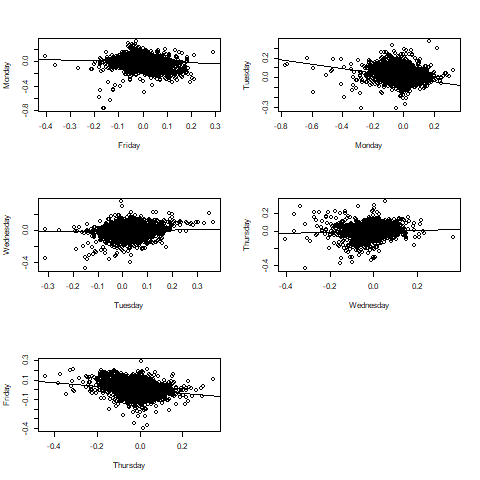

In [90]:
%%R
# Let's visualize our data. We will draw a scatter plot and the linear regression. 
layout(matrix(c(1,2,3,4,5,6), nrow = 3, ncol = 2, byrow = TRUE))
plot(Monday_Friday_F$logreturn,Monday_Friday_M$logreturn,
    xlab = "Friday", ylab = "Monday")
abline(fit_F_M_sig)
plot(Monday_Tuesday_M$logreturn,Monday_Tuesday_Tu$logreturn,
    xlab = "Monday", ylab = "Tuesday")
abline(fit_M_Tu_sig)
plot(Tuesday_Wednesday_Tu$logreturn,Tuesday_Wednesday_W$logreturn,
    xlab = "Tuesday", ylab = "Wednesday")
abline(fit_Tu_W_sig)
plot(Wednesday_Thursday_W$logreturn,Wednesday_Thursday_Th$logreturn,
    xlab = "Wednesday", ylab = "Thursday")
abline(fit_W_Th_sig)
plot(Thursday_Friday_Th$logreturn,Thursday_Friday_F$logreturn,
    xlab = "Thursday", ylab = "Friday")
abline(fit_Th_F_sig)

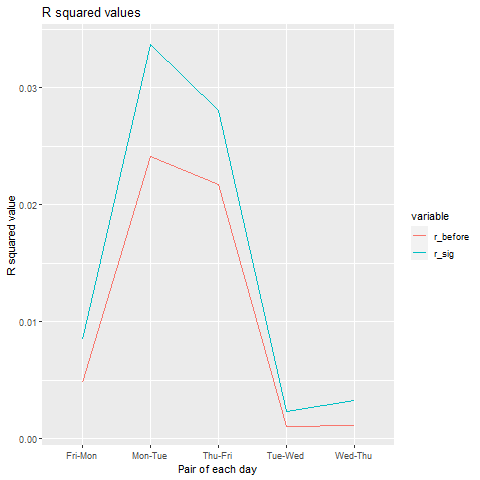

In [91]:
%%R
#We will also visualize the R-squared values and the coefficients for the pairs for the model that only includes the significant industries

#First, we need to save the R-squared values and the coefficents.
fit_F_M_sig_R2 = summary(fit_F_M_sig)$r.squared
fit_M_Tu_sig_R2 = summary(fit_M_Tu_sig)$r.squared
fit_Tu_W_sig_R2 = summary(fit_Tu_W_sig)$r.squared
fit_W_Th_sig_R2 = summary(fit_W_Th_sig)$r.squared
fit_Th_F_sig_R2 = summary(fit_Th_F_sig)$r.squared
fit_F_M_sig_Beta = fit_F_M_sig$coef[2]
fit_M_Tu_sig_Beta = fit_M_Tu_sig$coef[2]
fit_Tu_W_sig_Beta = fit_Tu_W_sig$coef[2]
fit_W_Th_sig_Beta = fit_W_Th_sig$coef[2]
fit_Th_F_sig_Beta = fit_Th_F_sig$coef[2]

# Let's store these values
r_sig = c(fit_F_M_sig_R2,fit_M_Tu_sig_R2,fit_Tu_W_sig_R2,fit_W_Th_sig_R2,fit_Th_F_sig_R2)
beta_sig = c(fit_F_M_sig_Beta,fit_M_Tu_sig_Beta,fit_Tu_W_sig_Beta,fit_W_Th_sig_Beta,fit_Th_F_sig_Beta)

# We will calculate how much the R-squared values and coefficients changed when using all the industries and only the significant industries
r_improve = (r_sig-r_before)/r_before
beta_improve = (beta_sig-beta_before)/beta_before

# Let's plot both R-squared values
names = c("Fri-Mon","Mon-Tue","Tue-Wed","Wed-Thu","Thu-Fri")
r_table =data.frame(names,r_before,r_sig)
r_melt <- melt(r_table, id = "names")
ggplot(data = r_melt) +
  geom_line(aes(x = names, y = value, colour = variable, group = variable))+ labs(x = "Pair of each day",y = "R squared value",title = "R squared values")

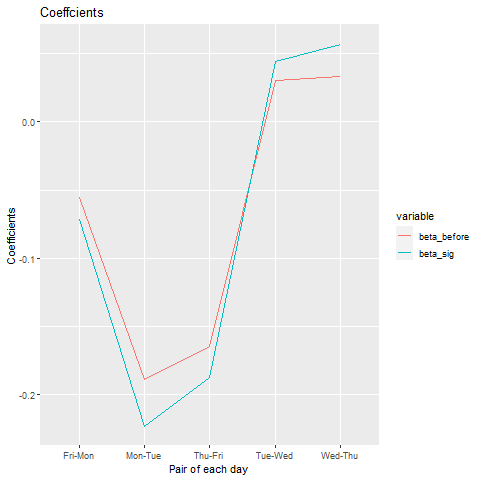

In [92]:
%%R
# Let's plot both coefficeitns
names = c("Fri-Mon","Mon-Tue","Tue-Wed","Wed-Thu","Thu-Fri")
beta_table =data.frame(names,beta_before,beta_sig)
beta_melt <- melt(beta_table, id = "names")
ggplot(data = beta_melt) +
  geom_line(aes(x = names, y = value, colour = variable, group = variable))+ labs(x = "Pair of each day",y = "Coefficients",title = "Coeffcients")

From the plot above, the $R^2$ for the model that examines the relationship between Monday and Friday stock returns is small. In addition, the relationship was not the largest compared to other pairs. Therefore, the results for S&P 500 for 2017 did not replicate. The overall data indicates that the stock returns of Friday is not systematically and consistently related to that of Next Monday.

----
## Tackling Objective 3 <a clas ="anchor" id = "tackling-objective-3"></a>

With our historical data of the stock market, we can use this information to see if we can utilize the days of the week to better predict the future return. 

The intuition is, if the significant Monday-Friday relationship is strong enough, we should be able to use the historical data to predict the future easier than the other consecutive day pairs. 

We will try to fit time series model with our data, and calculate the rate of companies that Friday/Monday data can be fitted with a time series model, then we will compare if there's a different between Monday-Friday with other pairs of the days. 

To illustrate what we do in detail, let's first focus on a company in our dataset. 

### Importing the data for S&P 500 constituents in 2017 <a clas ="anchor" id = "3_2017"></a>

In [94]:
%%R
# Let's first import the data
SP500 <- read.csv('SP500_2014_2017_stacked.csv')

#### Example: Agilent Techonologies

In [95]:
%%R
# We wil take Agilent Technologies as an example. It's ticker is A
A <- subset(SP500, Ticker=="A", select=c(Date,logreturn,days))
# Make sure the data column have the right format to be used in time series
A$Date <- as.Date(A$Date)


#First, let's check what we have
table(A$days)


   Friday    Monday  Thursday   Tuesday Wednesday 
      201       188       203       207       208 


Notice that we have a not equal number of weekdays in the dataset that we have some missing values. this is not good for time series analysis.

In [116]:
%%R
# Now check which days of the week we are missing
install.packages("dplyr")
library(dplyr)

# Define a list of weekdays
weekday <- c("Monday","Tuesday","Wednesday","Thursday","Friday")

# Checking for jumping days using a double for loop
for (i in weekday){
  for (j in weekday){
    k <- subset(A, days==i & lead(days)==j)
    #print patterns that have value
    if (nrow(k)!=0){
      print(c(i,j,nrow(k)))
    }
  }
}

R[write to console]: Warning:
R[write to console]:  package 'dplyr' is in use and will not be installed



[1] "Monday"  "Tuesday" "187"    
[1] "Monday"    "Wednesday" "1"        
[1] "Tuesday"   "Wednesday" "207"      
[1] "Wednesday" "Thursday"  "202"      
[1] "Wednesday" "Friday"    "6"        
[1] "Thursday" "Monday"   "8"       
[1] "Thursday" "Friday"   "195"     
[1] "Friday" "Monday" "180"   
[1] "Friday"  "Tuesday" "20"     


We can see that we only have "one day jump" kind of missing data. We now want to create a new dataset that fulfill the missing values as average of the previous day and next day

In [97]:
%%R
# Let's generate an empty dataset
newdf <-data.frame(Date=as.Date(character()), logreturn=double(),  days=character(), stringsAsFactors=FALSE) 

# Run a loop to fulfill those missing days
for (i in 1:nrow(A)-1){
  #if jumping days, fulfill it with average of yesterday and tomorrow
  ## if not just copy the row
  if ((A$days[i]=="Friday") && (A$days[i+1]=="Tuesday")){
    misdate <- A$Date[i+1]-1
    misvalue <- (A$logreturn[i+1]+A$logreturn[i-1])/2
    misdays <- "Monday"
    newdf <- rbind(newdf,A[i,])
    newdf <- rbind(newdf, data.frame(Date=misdate, logreturn=misvalue, days=misdays))
  }
  else if((A$days[i]=="Monday") && (A$days[i+1]=="Wednesday")){
    misdate <- A$Date[i+1]-1
    misvalue <- (A$logreturn[i+1]+A$logreturn[i-1])/2
    misdays <- "Tuesday"
    newdf <- rbind(newdf,A[i,])
    newdf <- rbind(newdf, data.frame(Date=misdate, logreturn=misvalue, days=misdays))
  }
  else if((A$days[i]=="Wednesday") && (A$days[i+1]=="Friday")){
    misdate <- A$Date[i+1]-1
    misvalue <- (A$logreturn[i+1]+A$logreturn[i-1])/2
    misdays <- "Thursday"
    newdf <- rbind(newdf,A[i,])
    newdf <- rbind(newdf, data.frame(Date=misdate, logreturn=misvalue, days=misdays))
  }
  else if((A$days[i]=="Thursday") && (A$days[i+1]=="Monday")){
    misdate <- A$Date[i+1]-1
    misvalue <- (A$logreturn[i+1]+A$logreturn[i-1])/2
    misdays <- "Friday"
    newdf <- rbind(newdf,A[i,])
    newdf <- rbind(newdf, data.frame(Date=misdate, logreturn=misvalue, days=misdays))
  }
  else{
    newdf <- rbind(newdf,A[i,])
  }
}
# Add the last row that's not included in the for loop since the +1 argument
newdf <- rbind(newdf,tail(A,1))

# Let's check again for missing value

# Check what kind of days we are missing by checking jumping days
for (i in weekday){
  for (j in weekday){
    k <- subset(newdf, days==i & lead(days)==j)
    #print patterns that have value
    if (nrow(k)!=0){
      print(c(i,j,nrow(k)))
    }
  }
}

[1] "Monday"  "Tuesday" "208"    
[1] "Tuesday"   "Wednesday" "208"      
[1] "Wednesday" "Thursday"  "208"      
[1] "Thursday" "Friday"   "209"     
[1] "Friday" "Monday" "208"   


We can see that there's no longer missing values. After the cleaning, we are ready to do the time series analysis

#### Time Series Analysis

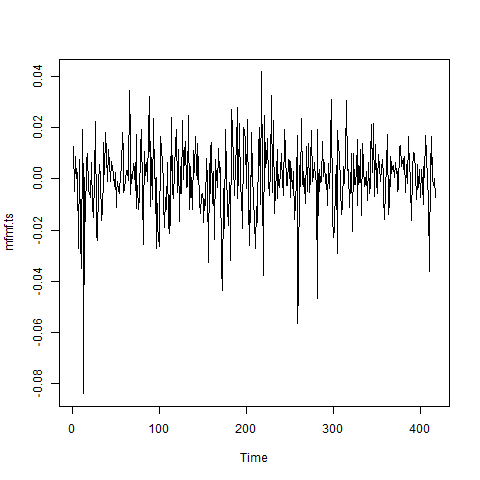

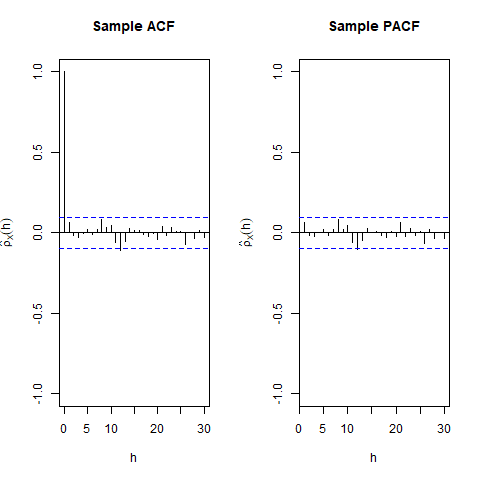

In [98]:
%%R
# Let's subset the data for only Friday onday
mfmf <- subset(newdf, days=="Friday" | days=="Monday")

# We will convert the subset to time series
mfmf.ts <- ts(mfmf[,2])

# Let's plot raw data
plot(mfmf.ts)
# We will check for sample acf and sample pacf
par(mfrow=c(1,2))
acf(mfmf.ts ,lag.max = 30, na.action=na.pass ,main="Sample ACF",
ylim=c(-1,1),xlab="h",ylab=expression(hat(rho)[X](h)))
pacf(mfmf.ts ,lag.max = 30, na.action=na.pass,main="Sample PACF",
ylim=c(-1,1),xlab="h",ylab=expression(hat(rho)[X](h)))

We will try to fit only ar model to the data using yule-walker

In [99]:
%%R
# We will use ar with tyle-walker to find the optimal order of ar model
# Ar order
fit <- ar(mfmf.ts, aic = TRUE, order.max = 5, method = c("yule-walker"))
# Let's check output
fit
# We can only call the part with the order
fit$order

[1] 0


The results indicate that no ar model can be fit as the order is 0. We will now try to fit any arima model to the data using auto.arima.

In [100]:
%%R
install.packages("forecast")
library(forecast)
fit2 <- auto.arima(mfmf.ts)

R[write to console]: Installing package into 'C:/Users/SungbinYouk-PC/Documents/R/win-library/4.0'
(as 'lib' is unspecified)

R[write to console]: also installing the dependencies 'xts', 'TTR', 'quadprog', 'quantmod', 'fracdiff', 'tseries', 'urca'


R[write to console]: trying URL 'https://cran.microsoft.com/bin/windows/contrib/4.0/xts_0.12.1.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 943808 bytes (921 KB)

R[write to console]: downloaded 921 KB


R[write to console]: trying URL 'https://cran.microsoft.com/bin/windows/contrib/4.0/TTR_0.24.2.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 529873 bytes (517 KB)

R[write to console]: downloaded 517 KB


R[write to console]: trying URL 'https://cran.microsoft.com/bin/windows/contrib/4.0/quadprog_1.5-8.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 50240 bytes (49 KB)

R[write to console]: downloaded 49 KB


R[write to 

package 'xts' successfully unpacked and MD5 sums checked
package 'TTR' successfully unpacked and MD5 sums checked
package 'quadprog' successfully unpacked and MD5 sums checked
package 'quantmod' successfully unpacked and MD5 sums checked
package 'fracdiff' successfully unpacked and MD5 sums checked
package 'tseries' successfully unpacked and MD5 sums checked
package 'urca' successfully unpacked and MD5 sums checked
package 'forecast' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\SungbinYouk-PC\AppData\Local\Temp\RtmpCI1NaH\downloaded_packages


R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: This is forecast 8.15 
  Need help getting started? Try the online textbook FPP:
  http://otexts.com/fpp2/



In [101]:
%%R
# Let's check what the output looks like
fit2

Series: mfmf.ts 
ARIMA(0,0,0) with zero mean 

sigma^2 estimated as 0.0001912:  log likelihood=1193.49
AIC=-2384.99   AICc=-2384.98   BIC=-2380.95


In [104]:
%%R
# We can only call the part with the parameter
fit2$arma

[1] 0 0 0 0 1 0 0


The results indicate that we can't fit any model with this data. All parameter is zero and the period is 1 means non-seasonal. 

The above code concludes our analysis to one companies data, now for the following codes, we are going to apply the above steps to all the companies, and then calculate the ratio of companies that can fit any/ar-only model. Let's examine the time series at scale. 

#### Analyzing across all constituents

In [106]:
%%R
#Let's first get the list of the constituents (i.e. the ticker for the companies)
company <- unique(SP500[c("Ticker","Industry")])
#We will create an empty list
complist <- c()
#Let's run for loop to get company list
for (i in company$Ticker){
  complist <- c(complist, i)
}

# Let's create empty dataframe for ar only, will later use to keep all result from the analysis of fitted model
result <-data.frame(Ticker=character(), ar = double(), industry=character(), stringsAsFactors=FALSE) 
result.2 <-result
result.3 <-result
result.4 <-result
result.5 <-result

# We will create empty dataframe for fit any
result2 <-data.frame(Ticker=character(), pes = double(), qes = double(), Pes = double(), Qes = double(),
                       des= double(), Des = double(), ses = double(), industry=character(), stringsAsFactors=FALSE) 
result2.2 <-result2
result2.3 <-result2
result2.4 <-result2
result2.5 <-result2

# Let's write a large loop for all the companies. For every company, repeat what we do in previous part
for (c in 1:length(complist)){
  #This is the data cleaning process
  #Let's subset the company
  comp <- subset(SP500, Ticker==complist[c], select=c(Date,logreturn,days))
  comp$Date <- as.Date(comp$Date)
  
  #We will create new empty dataset
  newdf <-data.frame(Date=as.Date(character()), logreturn=double(), days=character(), stringsAsFactors=FALSE) 
  
  #Let's run for loop to fulfill those missing days
    for (i in 1:nrow(comp)-1){
      #If jumping days, fulfill it with average of yesterday and tomorrow
      ## If not, just copy the row
      if ((comp$days[i]=="Friday") && (comp$days[i+1]=="Tuesday")){
        misdate <- comp$Date[i+1]-1
        misvalue <- (comp$logreturn[i+1]+comp$logreturn[i-1])/2
        misdays <- "Monday"
        newdf <- rbind(newdf,comp[i,])
        newdf <- rbind(newdf, data.frame(Date=misdate, logreturn=misvalue, days=misdays))
      }
      else if((comp$days[i]=="Monday") && (comp$days[i+1]=="Wednesday")){
        misdate <- comp$Date[i+1]-1
        misvalue <- (comp$logreturn[i+1]+comp$logreturn[i-1])/2
        misdays <- "Tuesday"
        newdf <- rbind(newdf,comp[i,])
        newdf <- rbind(newdf, data.frame(Date=misdate, logreturn=misvalue, days=misdays))
      }
      else if((comp$days[i]=="Wednesday") && (comp$days[i+1]=="Friday")){
        misdate <- comp$Date[i+1]-1
        misvalue <- (comp$logreturn[i+1]+comp$logreturn[i-1])/2
        misdays <- "Thursday"
        newdf <- rbind(newdf,comp[i,])
        newdf <- rbind(newdf, data.frame(Date=misdate, logreturn=misvalue, days=misdays))
      }
      else if((comp$days[i]=="Thursday") && (comp$days[i+1]=="Monday")){
        misdate <- comp$Date[i+1]-1
        misvalue <- (comp$logreturn[i+1]+comp$logreturn[i-1])/2
        misdays <- "Friday"
        newdf <- rbind(newdf,comp[i,])
        newdf <- rbind(newdf, data.frame(Date=misdate, logreturn=misvalue, days=misdays))
      }
      else{
        newdf <- rbind(newdf,comp[i,])
      }
    }
    newdf <- rbind(newdf,tail(comp,1))
    
  #This is the process of subseting data by days
    
  #We will subset the data of different pairs
    mfmf <- subset(newdf, days=="Friday" | days=="Monday")
    mfmf.2 <- subset(newdf, days=="Tuesday" | days=="Monday")
    mfmf.3 <- subset(newdf, days=="Wednesday" | days=="Tuesday")
    mfmf.4 <- subset(newdf, days=="Wednesday" | days=="Thursday")
    mfmf.5 <- subset(newdf, days=="Friday" | days=="Thursday")

  #Let's convert to time series
    mfmf.ts <- ts(mfmf[,2])
    mfmf.ts.2 <- ts(mfmf.2[,2])
    mfmf.ts.3 <- ts(mfmf.3[,2])
    mfmf.ts.4 <- ts(mfmf.4[,2])
    mfmf.ts.5 <- ts(mfmf.5[,2])
    
    
  # Approach one, fit ar only for all company
  
  #ar order
    fit <- ar(mfmf.ts, aic = TRUE, order.max = 5, method = c("yule-walker"))
    ord = fit$order
  result <- rbind(result,data.frame(Ticker=complist[c],ar=ord, industry=company$Industry[c]))
  
  #ar order2
    fit <- ar(mfmf.ts.2, aic = TRUE, order.max = 5, method = c("yule-walker"))
    ord = fit$order
  result.2 <- rbind(result.2,data.frame(Ticker=complist[c],ar=ord, industry=company$Industry[c]))
  
  #ar order3
    fit <- ar(mfmf.ts.3, aic = TRUE, order.max = 5, method = c("yule-walker"))
    ord = fit$order
  result.3 <- rbind(result.3,data.frame(Ticker=complist[c],ar=ord, industry=company$Industry[c]))
  
  #ar order4
    fit <- ar(mfmf.ts.4, aic = TRUE, order.max = 5, method = c("yule-walker"))
    ord = fit$order
  result.4 <- rbind(result.4,data.frame(Ticker=complist[c],ar=ord, industry=company$Industry[c]))
  
  #ar order5
    fit <- ar(mfmf.ts.5, aic = TRUE, order.max = 5, method = c("yule-walker"))
    ord = fit$order
  result.5 <- rbind(result.5,data.frame(Ticker=complist[c],ar=ord, industry=company$Industry[c]))
  
  
  #Approach two, fit all for all company

  
  #auto.arima 1
    fit <- auto.arima(mfmf.ts)
    p = fit$arma[1]
    q = fit$arma[2]
    P = fit$arma[3]
    Q = fit$arma[4]
    s = fit$arma[5]
    d = fit$arma[6]
    D = fit$arma[7]
  
    result2 <- rbind(result2,data.frame(Ticker=complist[c],pes=p, qes=q, Pes=P, Qes=Q, des=d, Des=D, ses=s,
                                        industry=company$Industry[c]))
    
    #auto.arima 2
    fit <- auto.arima(mfmf.ts.2)
    p = fit$arma[1]
    q = fit$arma[2]
    P = fit$arma[3]
    Q = fit$arma[4]
    s = fit$arma[5]
    d = fit$arma[6]
    D = fit$arma[7]
  
    result2.2 <- rbind(result2.2,data.frame(Ticker=complist[c],pes=p, qes=q, Pes=P, Qes=Q, des=d, Des=D, ses=s,
                                            industry=company$Industry[c]))
    
    #auto.arima 3
    fit <- auto.arima(mfmf.ts.3)
    p = fit$arma[1]
    q = fit$arma[2]
    P = fit$arma[3]
    Q = fit$arma[4]
    s = fit$arma[5]
    d = fit$arma[6]
    D = fit$arma[7]
  
    result2.3 <- rbind(result2.3,data.frame(Ticker=complist[c],pes=p, qes=q, Pes=P, Qes=Q, des=d, Des=D, ses=s,
                                            industry=company$Industry[c]))
    
    #auto.arima 4
    fit <- auto.arima(mfmf.ts.4)
    p = fit$arma[1]
    q = fit$arma[2]
    P = fit$arma[3]
    Q = fit$arma[4]
    s = fit$arma[5]
    d = fit$arma[6]
    D = fit$arma[7]
  
    result2.4 <- rbind(result2.4,data.frame(Ticker=complist[c],pes=p, qes=q, Pes=P, Qes=Q, des=d, Des=D, ses=s,
                                            industry=company$Industry[c]))
    
    #auto.arima 5
    fit <- auto.arima(mfmf.ts.5)
    p = fit$arma[1]
    q = fit$arma[2]
    P = fit$arma[3]
    Q = fit$arma[4]
    s = fit$arma[5]
    d = fit$arma[6]
    D = fit$arma[7]
  
    result2.5 <- rbind(result2.5,data.frame(Ticker=complist[c],pes=p, qes=q, Pes=P, Qes=Q, des=d, Des=D, ses=s,
                                            industry=company$Industry[c]))
}

Let's get a summary of our results 

In [112]:
%%R

#Let 's create new matrix for summary result
sum_ratio <- matrix(data=NA, nrow=2, ncol=6)

#Ar only approach to summarize the result from approach one with aggregation


#We will create table
industry <- result
#Let's create a column called hasar means if the ar order is not 0
industry$hasar <- 0
industry$hasar[industry$a>0] <- 1
#We can now calculate the rate of industries
sum_ratio[1,2] <- sum(industry$hasar)/nrow(industry)

#We will create table 2
industry.2 <- result.2
industry.2$hasar <- 0
industry.2$hasar[industry.2$a>0] <- 1
#We can now calculate the rate of industries
sum_ratio[1,3] <- sum(industry.2$hasar)/nrow(industry.2)

#We will repeate this for table 3,4,5
industry.3 <- result.3
industry.3$hasar <- 0
industry.3$hasar[industry.3$a>0] <- 1
sum_ratio[1,4] <- sum(industry.3$hasar)/nrow(industry.3)


industry.4 <- result.4
industry.4$hasar <- 0
industry.4$hasar[industry.4$a>0] <- 1
sum_ratio[1,5] <- sum(industry.4$hasar)/nrow(industry.4)

industry.5 <- result.5
industry.5$hasar <- 0
industry.5$hasar[industry.5$a>0] <- 1
sum_ratio[1,6] <- sum(industry.5$hasar)/nrow(industry.5)


#Fit all approach to summarize the result from approach one with aggregation


# We will create a table
industry2 <- result2
# Let's create a column called model means if a model can be fitted
industry2$model <- 0
industry2$model[industry2$pes>0|industry2$qes>0|industry2$Pes>0|industry2$Qes>0|industry2$des>0|industry2$Des>0] <- 1
# We can now calculate the rate of industries
sum_ratio[2,2] <- sum(industry2$model)/nrow(industry2)

# We will repeat this for table 2,3,4,5
industry2.2 <- result2.2
industry2.2$model <- 0
industry2.2$model[industry2.2$pes>0|industry2.2$qes>0|industry2.2$Pes>0|industry2.2$Qes>0|industry2.2$des>0|industry2.2$Des>0] <- 1
sum_ratio[2,3] <- sum(industry2.2$model)/nrow(industry2.2)

industry2.3 <- result2.3
industry2.3$model <- 0
industry2.3$model[industry2.3$pes>0|industry2.3$qes>0|industry2.3$Pes>0|industry2.3$Qes>0|industry2.3$des>0|industry2.3$Des>0] <- 1
sum_ratio[2,4] <- sum(industry2.3$model)/nrow(industry2.3)

industry2.4 <- result2.4
industry2.4$model <- 0
industry2.4$model[industry2.4$pes>0|industry2.4$qes>0|industry2.4$Pes>0|industry2.4$Qes>0|industry2.4$des>0|industry2.4$Des>0] <- 1
sum_ratio[2,5] <- sum(industry2.4$model)/nrow(industry2.4)

industry2.5 <- result2.5
industry2.5$model <- 0
industry2.5$model[industry2.5$pes>0|industry2.5$qes>0|industry2.5$Pes>0|industry2.5$Qes>0|industry2.5$des>0|industry2.5$Des>0] <- 1
sum_ratio[2,6] <- sum(industry2.5$model)/nrow(industry2.5)


# Let's tidy up the summary
sum_ratio[1,1]<-"AR only"
sum_ratio[2,1]<-"Fit all"
colnames(sum_ratio) <- c("method","Friday-Monday", "M-T", "T-W", "W-TH", "TH-F")
sum_ratio

     method    Friday-Monday       M-T                 T-W                
[1,] "AR only" "0.356818181818182" "0.459090909090909" "0.470454545454545"
[2,] "Fit all" "0.302272727272727" "0.456818181818182" "0.454545454545455"
     W-TH                TH-F               
[1,] "0.279545454545455" "0.363636363636364"
[2,] "0.247727272727273" "0.336363636363636"


Both approaches show that the Friday-Monday does not provide a strong ratio when using past data point to predict future returns using a time series model.

We can also break down the result using industry to observe if some industry shows more pattern than others.

In [126]:
%%R
#This is the ar only approach

#We will create empty matrix
sum_ratio_industry<-matrix()

#We can summarize by industry for each pair
sum_ratio_industry<- industry %>% 
  group_by(industry) %>% 
  dplyr::summarise("FM"=mean(hasar), n=n())

joint <- industry.2 %>% 
  group_by(industry) %>% 
  dplyr::summarise("MT"=mean(hasar))
#joint the matrix using left join
sum_ratio_industry<-left_join(sum_ratio_industry,joint, by="industry")

joint <- industry.3 %>% 
  group_by(industry) %>% 
  dplyr::summarise("TW"=mean(hasar))
sum_ratio_industry<-left_join(sum_ratio_industry,joint, by="industry")

joint <- industry.4 %>% 
  group_by(industry) %>% 
  dplyr::summarise("WTH"=mean(hasar))
sum_ratio_industry<-left_join(sum_ratio_industry,joint, by="industry")

joint <- industry.5 %>% 
  group_by(industry) %>% 
  dplyr::summarise("THF"=mean(hasar))
sum_ratio_industry<-left_join(sum_ratio_industry,joint, by="industry")

#Let's reorder the columns 
sum_ratio_industry <- sum_ratio_industry[,c(1,3,2,4,5,6,7)]
sum_ratio_industry


# A tibble: 117 x 7
   industry                       n    FM    MT    TW   WTH   THF
   <chr>                      <int> <dbl> <dbl> <dbl> <dbl> <dbl>
 1 ""                             5 0.2   0.2   0     0.2   0.8  
 2 "Advertising Agencies"         2 0.5   0.5   0     0.5   0    
 3 "Aerospace & Defense"          6 0.167 0.5   0.167 0.5   0.333
 4 "Agricultural Inputs"          3 0     0     0.667 0.333 0.333
 5 "Airlines"                     5 0.4   0.2   0.2   0.2   0.2  
 6 "Apparel Manufacturing"        6 0.667 0.5   0.5   0.167 0.333
 7 "Apparel Retail"               4 0     0     0.5   0     0    
 8 "Asset Management"             9 0.333 0.667 0.667 0.111 0.111
 9 "Auto & Truck Dealerships"     1 0     1     1     0     1    
10 "Auto Manufacturers"           2 0     0     0.5   0     0    
# ... with 107 more rows


In [125]:
%%R
#This is the fit all approach

# we can create empty matrix
sum_ratio_industry2<-matrix()

# Let's summarize by industry for each pair
sum_ratio_industry2<- industry2 %>% 
  group_by(industry) %>% 
  dplyr::summarise("FM"=mean(model), n=n())

joint <- industry2.2 %>% 
  group_by(industry) %>% 
  dplyr::summarise("MT"=mean(model))
#Let's join the matrix using left join
sum_ratio_industry2<-left_join(sum_ratio_industry2,joint, by="industry")

#Let's repeat the process
joint <- industry2.3 %>% 
  group_by(industry) %>% 
  dplyr::summarise("TW"=mean(model))
sum_ratio_industry2<-left_join(sum_ratio_industry2,joint, by="industry")

joint <- industry2.4 %>% 
  group_by(industry) %>% 
  dplyr::summarise("WTH"=mean(model))
        
sum_ratio_industry2<-left_join(sum_ratio_industry2,joint, by="industry")

joint <- industry2.5 %>% 
  group_by(industry) %>% 
  dplyr::summarise("THF"=mean(model))
sum_ratio_industry2<-left_join(sum_ratio_industry2,joint, by="industry")

sum_ratio_industry2 <- sum_ratio_industry2[,c(1,3,2,4,5,6,7)]
sum_ratio_industry2

# A tibble: 117 x 7
   industry                       n    FM    MT    TW   WTH   THF
   <chr>                      <int> <dbl> <dbl> <dbl> <dbl> <dbl>
 1 ""                             5 0.2   0.6   0.2   0.2   0.4  
 2 "Advertising Agencies"         2 1     1     1     0.5   0    
 3 "Aerospace & Defense"          6 0.333 0.167 0.167 0.667 0.333
 4 "Agricultural Inputs"          3 0.333 0     0     0     0    
 5 "Airlines"                     5 0.6   0.2   0.4   0     0.6  
 6 "Apparel Manufacturing"        6 0.5   0.333 0.5   0.167 0.333
 7 "Apparel Retail"               4 0     0     0.25  0     0    
 8 "Asset Management"             9 0.333 0.333 0.667 0.111 0    
 9 "Auto & Truck Dealerships"     1 0     1     0     0     0    
10 "Auto Manufacturers"           2 0.5   0     0     0     0.5  
# ... with 107 more rows


In [124]:
%%R
#We will filter the industry that have Friday Monday highest rates
mf_top_ar <- sum_ratio_industry %>% 
  filter(FM>MT & FM>TW & FM>WTH & FM>THF)
mf_top_ar

#We will filter the industry that have Friday Monday highest rates
mf_top_all <- sum_ratio_industry2 %>% 
  filter(FM>MT & FM>TW & FM>WTH & FM>THF)
mf_top_all

#Let;s find the industries that the two methods intersect
intersect( mf_top_ar$industry, mf_top_all$industry) 

[1] "Home Improvement Retail"  "Industrial Distribution" 
[3] "Residential Construction" "Restaurants"             
[5] "Specialty Retail"         "Tobacco"                 


## Conclusion  <a clas ="anchor" id = "conclusion"></a>

This project examined the two definitions of Monday effect. We examined the S&P 500 constituents for 2017 and 2021. By examining the two dataset, we can make the conclusion that Monday effect (either of the definitions) is an urban myth. The results didn't replicate across the two datasets. In certain cases, we did see the stock returns of Monday being the lowest compared to other days of the week. We also saw instances when Monday's stock returns were correlated to that of Friday. However, this pattern was not consistent across years and across industries. Additionally, the effect sizes of the relationship between stock returns of Monday and Friday were small. Therefore, the relationship was statistically significant, but practically insignificant. As we used parametric test, the statistical significant values may be Type I error. The time series analysis took the entire history of the consecutive day pairs. Knowning the past Monday and Friday pattern did not predict the next Monday's stock returns. Therefore, we couldn't observe Monday effect on a larger scale as well.

Then, why do literature document Monday effect? We believe that this is a result of [confirmation bias](https://www.simplypsychology.org/confirmation-bias.html). As you can see in our results, Monday effect can be found when the data is subsetted by years, months, and industries. However, this is unreliable and unlikely to be replicated. 

Here is an analogy to make sense out of this. Get a piece of A4 paper. Take a kneedle an poke a hole in it using a kneedle. Now, take the paper and ask someone what it is. They will most likely say that it is a paper. So, if you look at the stock market as a whole (i.e. the paper), the efficient market hypothesis holds. However, if you look closely enough, you can find Monday effect (i.e. the hole). However, it is difficult to interpret why the Monday effect exists for the specific subset of data. 